In [1]:
#Group Project Script MSCA Big Data Winter 2022
# The following code includes data import, cleaning, feature engineering, and initial model setup

In [143]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType
from pyspark.sql.functions import to_timestamp, upper, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, StopWordsRemover, Word2Vec, VectorAssembler

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.appName('ZillowPrices').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g'), ('spark.sql.repl.eagerEval.enabled', True)])


In [4]:
## From HDFS or GCP?
HDFS = True

if HDFS:
    path = '/user/efischbein/data/group_project/'
    hos_path = '/user/efischbein/data/group_project/hospital/'
    z_path = '/user/efischbein/data/group_project/zillow_econ/'
else:
    path = 'gs://group-8-msca-bucket/'
    hos_path = 'gs://group-8-msca-bucket/'
    z_path = 'gs://group-8-msca-bucket/'

In [5]:
raw_df = spark.read.csv(path + "us_housing_prices", inferSchema=True, header=True)
Public_Schools = spark.read.csv(path + "Public_Schools.csv", \
    inferSchema=True, header=True)
CPI = spark.read.csv(path + "CPIHOSNS.csv", inferSchema=True, header=True)
ZVHI = spark.read.csv(path + "ZHVI_cln.csv", inferSchema=True, header=True)
Income = spark.read.csv(path + "Census_Income", inferSchema=True, header=True)
pre_2000 = spark.read.csv(path + "county_pre_2000_data_cln.csv", header=True)
hospital_ratings = spark.read.csv(hos_path + 'Hospital_General_Information.csv', \
    header = True)
hospital = spark.read.csv(hos_path + 'hospitals.csv', header = True)
crime = spark.read.csv(path + 'crime_data_w_population_and_crime_rate.csv',header = True)
CountyCrossWalk_Zillow = spark.read.csv(z_path + 'CountyCrossWalk_Zillow.csv',\
    header = True)

# DATA EXPLORATION, DATASET CREATION

In [6]:
df = raw_df
#SECTION 1 - Load base CSV file & analyze
# df = spark.read.csv("gs://group-8-msca-bucket/sales.csv", inferSchema=True, header=True)

In [7]:
df.describe()

DataFrame[summary: string, state: string, zip5: string, physical_address: string, city: string, county: string, property_id: string, sale_date: string, property_type: string, sale_price: string, seller_name: string, buyer_name: string, num_units: string, year_built: string, source_url: string, book: string, page: string]

In [8]:
df.show(3)

+-----+-----+-----------------+-------+---------+-----------+--------------------+--------------------+----------+-----------+----------+---------+----------+--------------------+----+----+
|state| zip5| physical_address|   city|   county|property_id|           sale_date|       property_type|sale_price|seller_name|buyer_name|num_units|year_built|          source_url|book|page|
+-----+-----+-----------------+-------+---------+-----------+--------------------+--------------------+----------+-----------+----------+---------+----------+--------------------+----+----+
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE|  408144009|1988-05-25 00:00:...|SINGLE FAMILY DWE...|         0|       null|      null|        1|      1965|https://ca-rivers...|null|null|
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE|  408144009|1989-03-17 00:00:...|SINGLE FAMILY DWE...|         0|       null|      null|        1|      1965|https://ca-rivers...|null|null|
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE| 

In [9]:
df.dtypes

[('state', 'string'),
 ('zip5', 'string'),
 ('physical_address', 'string'),
 ('city', 'string'),
 ('county', 'string'),
 ('property_id', 'string'),
 ('sale_date', 'string'),
 ('property_type', 'string'),
 ('sale_price', 'string'),
 ('seller_name', 'string'),
 ('buyer_name', 'string'),
 ('num_units', 'string'),
 ('year_built', 'string'),
 ('source_url', 'string'),
 ('book', 'string'),
 ('page', 'string')]

In [10]:
#SECTION 2 - Data Cleanup
#1. drop extra columns (seller_name, buyer_name, source_url, book, page)
#2. Dates - limited from 1970-2021
#3. Sale Price - not null, greater than 0
#4. City, State - remove null
#5. Num. Units -  must be 1
#6. Property Type - remove condos, mobile homes
#7. Num. Sales - must be greater than 1

In [11]:
#Data Cleanup - drop extra columns
df = df.drop("seller_name", "buyer_name", "source_url", "book", "page")

In [12]:
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

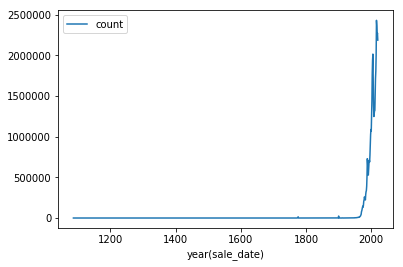

In [13]:
#home sales by year
sale_plt = df.filter(F.year(col('sale_date')) <= 2020).groupBy(F.year(col('sale_date'))).count().toPandas()
sale_plt = sale_plt.sort_values('year(sale_date)')
sale_plt = sale_plt.set_index('year(sale_date)')
sale_plt.plot(kind ='line')
plt.show()

In [14]:
#Data Cleanup - Dates: 1970 - 2021
df = df.withColumn('sale_date', F.to_date(F.unix_timestamp('sale_date', 'yyyy-MM-dd').cast('timestamp')))
df = df.filter((F.year(col("sale_date"))<=2021) & (F.year(col("sale_date"))>=1970))
df.select('sale_date').head(5)

[Row(sale_date=datetime.date(1988, 5, 25)),
 Row(sale_date=datetime.date(1989, 3, 17)),
 Row(sale_date=datetime.date(1991, 6, 18)),
 Row(sale_date=datetime.date(1994, 12, 12)),
 Row(sale_date=datetime.date(2003, 2, 28))]

In [15]:
#Data Cleanup - Sale Price
df = df.withColumn('sale_price', df.sale_price.cast('float'))
df = df.filter(col("sale_price").isNotNull()).filter(col("sale_price")>0)
df.select('sale_price').head(5)

[Row(sale_price=59000.0),
 Row(sale_price=280000.0),
 Row(sale_price=381591.0),
 Row(sale_price=592000.0),
 Row(sale_price=585000.0)]

In [16]:
df.describe("sale_date", "sale_price").show()

+-------+-----------------+
|summary|       sale_price|
+-------+-----------------+
|  count|         42865931|
|   mean|493120.9679655622|
| stddev| 6699651.50878324|
|    min|              1.0|
|    max|            8.2E9|
+-------+-----------------+



In [17]:
#Data Cleanup - remove null cities & states
df = df.filter((col("city").isNotNull()) & (col("state").isNotNull()) & (col("physical_address").isNotNull()) & (col("zip5").isNotNull()))

In [18]:
#top cities
df.groupBy('city','state').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+-------+
|                city|state|  count|
+--------------------+-----+-------+
|         LOS ANGELES|   CA|1403176|
|       NEW YORK CITY|   NY|1260613|
|               TAMPA|   FL|1074407|
|        PHILADELPHIA|   PA| 738332|
|            LAKELAND|   FL| 542238|
|             SEATTLE|   WA| 413323|
|      VIRGINIA BEACH|   VA| 365435|
|        INDIANAPOLIS|   IN| 329493|
|           DAVENPORT|   FL| 306982|
|UNINCORPORATED CO...|   FL| 303591|
+--------------------+-----+-------+
only showing top 10 rows



In [19]:
#Data Cleanup - View number of units, want to only be 1
df = df.filter(col('num_units')==1)
df.groupBy('num_units').count().orderBy('count', ascending=False).show()

+---------+-------+
|num_units|  count|
+---------+-------+
|        1|9742796|
+---------+-------+



In [20]:
#view property types
df.groupBy('property_type').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|       property_type|  count|
+--------------------+-------+
|SINGLE FAMILY RES...|2579548|
|                null|2104659|
|SINGLE FAMILY DWE...|1402975|
|         CONDOMINIUM| 784499|
|SINGLE FAMILY/SFR...| 440753|
|       SINGLE FAMILY| 421979|
|          ONE FAMILY| 301540|
|     SINGLE FAMILY R| 297952|
|       SINGLE-FAMILY| 179918|
|RESIDENTIAL < 10 ...| 158199|
|13  CONDOS - ELEV...| 148473|
|MULTI-FAMILY RESI...| 137634|
|01  ONE FAMILY HOMES| 126917|
|MOBILE HOME/MANUF...|  96049|
|13 CONDOS - ELEVA...|  83340|
|01 ONE FAMILY DWE...|  62157|
|01  ONE FAMILY DW...|  46209|
|      CONDO/TOWNHOME|  43164|
|ATTACHED HOUSING/...|  24802|
|28  COMMERCIAL CO...|  24360|
+--------------------+-------+
only showing top 20 rows



In [21]:
#Data Cleanup - filter out condos, mobile homes, rentals
df = df.where(~ col("property_type").like("%CONDO%"))
df = df.where(~ col("property_type").like("%MOBILE%HOME%"))
df = df.where(~ col("property_type").like("%RENTALS%"))

In [22]:
#view top properties
df.groupBy('city','state', 'physical_address', 'zip5', 'property_type').count().orderBy('count', ascending=False).show(25)

+------------+-----+--------------------+-----+--------------------+-----+
|        city|state|    physical_address| zip5|       property_type|count|
+------------+-----+--------------------+-----+--------------------+-----+
|PALM SPRINGS|   CA|  1800 S SUNRISE WAY|92264|SINGLE FAMILY DWE...|  106|
|PHILADELPHIA|   PA|   2018-32 WALNUT ST|19103|       SINGLE FAMILY|  102|
|  LONG BEACH|   CA|        225 W 6TH ST|90802|SINGLE FAMILY RES...|   97|
|PHILADELPHIA|   PA|        112 N 2ND ST|19106|       SINGLE FAMILY|   93|
|    LAKELAND|   FL|  2020 EDGEWOOD DR E|33803|ATTACHED HOUSING/...|   91|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33898|SINGLE FAMILY/SFR...|   86|
|PHILADELPHIA|   PA|224-30 W RITTENHO...|19103|       SINGLE FAMILY|   81|
|  LAKE WALES|   FL|   2285 BOY SCOUT RD|33853|SINGLE FAMILY/MUL...|   70|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33853|SINGLE FAMILY/SFR...|   62|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33898|SINGLE FAMILY/RES...|   61|
|PHILADELPHIA|   PA|2401 

In [23]:
from pyspark.sql.functions import rank
from pyspark.sql.window import Window

In [24]:
#Data Cleanup - filter dataframe based on window function to only show properties with only 1 sale
windowSpec = Window().partitionBy(['city','state', 'physical_address', 'zip5']).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("num_sales", F.count(col('city')).over(windowSpec)).filter(col('num_sales') > 1)

In [25]:
#SECTION 3 - Join Predictive Data Features

In [26]:
#SECTION 3a - Public Schools data

In [27]:
#Public_Schools.csv
# Public_Schools = spark.read.csv("gs://group-8-msca-bucket/Public_Schools.csv", inferSchema=True, header=True)

In [28]:
Public_Schools.describe()

DataFrame[summary: string, X: string, Y: string, OBJECTID: string, NCESID: string, NAME: string, ADDRESS: string, CITY: string, STATE: string, ZIP: string, ZIP4: string, TELEPHONE: string, TYPE: string, STATUS: string, POPULATION: string, COUNTY: string, COUNTYFIPS: string, COUNTRY: string, LATITUDE: string, LONGITUDE: string, NAICS_CODE: string, NAICS_DESC: string, SOURCE: string, SOURCEDATE: string, VAL_METHOD: string, VAL_DATE: string, WEBSITE: string, LEVEL_: string, ENROLLMENT: string, ST_GRADE: string, END_GRADE: string, DISTRICTID: string, FT_TEACHER: string, SHELTER_ID: string]

In [29]:
Public_Schools.dtypes
#Can maybe use the count of schools by city as a predictor? But would be correlated with city size

[('X', 'double'),
 ('Y', 'double'),
 ('OBJECTID', 'int'),
 ('NCESID', 'bigint'),
 ('NAME', 'string'),
 ('ADDRESS', 'string'),
 ('CITY', 'string'),
 ('STATE', 'string'),
 ('ZIP', 'string'),
 ('ZIP4', 'string'),
 ('TELEPHONE', 'string'),
 ('TYPE', 'string'),
 ('STATUS', 'int'),
 ('POPULATION', 'int'),
 ('COUNTY', 'string'),
 ('COUNTYFIPS', 'string'),
 ('COUNTRY', 'string'),
 ('LATITUDE', 'string'),
 ('LONGITUDE', 'double'),
 ('NAICS_CODE', 'double'),
 ('NAICS_DESC', 'string'),
 ('SOURCE', 'string'),
 ('SOURCEDATE', 'string'),
 ('VAL_METHOD', 'string'),
 ('VAL_DATE', 'string'),
 ('WEBSITE', 'string'),
 ('LEVEL_', 'string'),
 ('ENROLLMENT', 'int'),
 ('ST_GRADE', 'string'),
 ('END_GRADE', 'string'),
 ('DISTRICTID', 'int'),
 ('FT_TEACHER', 'int'),
 ('SHELTER_ID', 'string')]

In [30]:
#Public schools - First predictor variable - raw count by zip code
num_schools_zip = Public_Schools.groupby('ZIP').count()
num_schools_zip

DataFrame[ZIP: string, count: bigint]

In [31]:
#join predictor to base table
df = df.join(num_schools_zip, df['zip5'] == num_schools_zip['ZIP'], 'left').\
    select(df["*"],num_schools_zip["count"]).na.fill(0)

In [32]:
df = df.withColumnRenamed('count','zip_num_schools')
df.show(5)

+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+
|state| zip5|    physical_address| city|     county|property_id| sale_date|       property_type|sale_price|num_units|year_built|num_sales|zip_num_schools|
+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2002-01-10|SINGLE FAMILY RES...| 7303573.0|        1|      2003|        3|              5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2003-09-17|SINGLE FAMILY RES...|  458000.0|        1|      2003|        3|              5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2012-08-02|SINGLE FAMILY RES...|  399003.0|        1|      2003|        3|              5|
|   CA|93510|1940 SHADOW CANYO...|ACTON|LOS ANGELES| 3056032042|1991-0

In [33]:
#Public schools - Second predictor variable - number of schools by city
num_schools_city = Public_Schools.groupby('city', 'state').count()
num_schools_city

DataFrame[city: string, state: string, count: bigint]

In [34]:
#join predictor to base table
df = df.join(num_schools_city, (df['city'] == num_schools_city['city']) & \
             (df['state'] == num_schools_city['state']), 'left').\
             select(df["*"],num_schools_city["count"]).na.fill(0)

In [35]:
df = df.withColumnRenamed('count','city_num_schools')
df.show(5)

+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+----------------+
|state| zip5|    physical_address| city|     county|property_id| sale_date|       property_type|sale_price|num_units|year_built|num_sales|zip_num_schools|city_num_schools|
+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+----------------+
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2002-01-10|SINGLE FAMILY RES...| 7303573.0|        1|      2003|        3|              5|               5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2003-09-17|SINGLE FAMILY RES...|  458000.0|        1|      2003|        3|              5|               5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2012-08-02|SINGLE FAMILY RES...|  399003.0|        1|      2003|        3|  

In [36]:
#Public schools - Third predictor variable - Student Teacher Ratio by Zip
st_ratio_zip = Public_Schools.filter((col('ENROLLMENT') != -1) & (col('FT_TEACHER') != -1))
st_ratio_zip = st_ratio_zip.groupby('ZIP').agg((F.sum(st_ratio_zip.ENROLLMENT) / F.sum(st_ratio_zip.FT_TEACHER)).alias('zip_st_ratio'))
st_ratio_zip.show(5, vertical=True)

-RECORD 0--------------------------
 ZIP          | 49307              
 zip_st_ratio | 18.832167832167833 
-RECORD 1--------------------------
 ZIP          | 55371              
 zip_st_ratio | 17.296296296296298 
-RECORD 2--------------------------
 ZIP          | 27317              
 zip_st_ratio | 16.074074074074073 
-RECORD 3--------------------------
 ZIP          | 60081              
 zip_st_ratio | 12.825396825396826 
-RECORD 4--------------------------
 ZIP          | 72472              
 zip_st_ratio | 13.511811023622048 
only showing top 5 rows



In [37]:
#join predictor to base table
df = df.join(st_ratio_zip, df['zip5'] == st_ratio_zip['ZIP'], 'left').\
    select(df["*"],st_ratio_zip["zip_st_ratio"])

In [38]:
#Public schools - Fourth predictor variable - Student Teacher Ratio by City
st_ratio_city = Public_Schools.filter((col('ENROLLMENT') != -1) & (col('FT_TEACHER') != -1))
st_ratio_city = st_ratio_city.groupby('city', 'state').agg((F.sum(st_ratio_city.ENROLLMENT) / F.sum(st_ratio_city.FT_TEACHER)).alias('city_st_ratio'))
st_ratio_city.show(5, vertical=True)

-RECORD 0---------------------------
 city          | STATESBORO         
 state         | GA                 
 city_st_ratio | 17.060606060606062 
-RECORD 1---------------------------
 city          | STATEN ISLAND      
 state         | NY                 
 city_st_ratio | 14.711904202864522 
-RECORD 2---------------------------
 city          | BANGOR             
 state         | PA                 
 city_st_ratio | 14.350961538461538 
-RECORD 3---------------------------
 city          | CARAWAY            
 state         | AR                 
 city_st_ratio | 10.210526315789474 
-RECORD 4---------------------------
 city          | WEST SAINT PAUL    
 state         | MN                 
 city_st_ratio | 15.44017094017094  
only showing top 5 rows



In [39]:
#join predictor to base table
df = df.join(st_ratio_city, (df['city'] == st_ratio_city['city']) & \
             (df['state'] == st_ratio_city['state']), 'left').\
             select(df["*"],st_ratio_city["city_st_ratio"]).na.fill(0)

In [40]:
df.show(10, vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002    

In [41]:
#SECTION 3b - Housing CPI
#Limitations, not specific to regions

In [42]:
#CPI
# CPI = spark.read.csv("gs://group-8-msca-bucket/CPIHOSNS.csv", inferSchema=True, header=True)

In [43]:
CPI.dtypes

[('DATE', 'timestamp'), ('CPIHOSNS', 'double')]

In [44]:
CPI = CPI.withColumn('month', F.month(col('DATE')))
CPI = CPI.withColumn('year', F.year(col('DATE')))
CPI.show(5)

+-------------------+--------+-----+----+
|               DATE|CPIHOSNS|month|year|
+-------------------+--------+-----+----+
|1967-01-01 00:00:00|    30.5|    1|1967|
|1967-02-01 00:00:00|    30.5|    2|1967|
|1967-03-01 00:00:00|    30.5|    3|1967|
|1967-04-01 00:00:00|    30.6|    4|1967|
|1967-05-01 00:00:00|    30.7|    5|1967|
+-------------------+--------+-----+----+
only showing top 5 rows



In [45]:
#join predictor to base table
df = df.join(CPI, (F.month(df['sale_date']) == CPI['month']) & \
             (F.year(df['sale_date']) == CPI['year']), 'left').\
             select(df["*"],CPI["CPIHOSNS"])

In [46]:
df.show(10, vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES   

In [47]:
#SECTION 3c - ZVHI
#Limitations, not all regions included, will leave as 0

In [48]:
#ZVHI
# ZVHI = spark.read.csv("gs://group-8-msca-bucket/ZHVI_cln.csv", inferSchema=True, header=True)
ZVHI.head(5)

[Row(Date='1/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127090),
 Row(Date='2/29/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127434),
 Row(Date='3/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127795),
 Row(Date='4/30/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=128532),
 Row(Date='5/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=129274)]

In [49]:
ZVHI = ZVHI.withColumn('Date', F.to_date(F.unix_timestamp('Date', 'MM/dd/yyyy').cast('timestamp')))
ZVHI.select('Date').head(5)

[Row(Date=datetime.date(2000, 1, 31)),
 Row(Date=datetime.date(2000, 2, 29)),
 Row(Date=datetime.date(2000, 3, 31)),
 Row(Date=datetime.date(2000, 4, 30)),
 Row(Date=datetime.date(2000, 5, 31))]

In [50]:
ZVHI.dtypes
#time series; could be useful to pivot, but seems redundant to the city index CSV

[('Date', 'date'),
 ('RegionID', 'int'),
 ('SizeRank', 'int'),
 ('RegionName', 'string'),
 ('RegionType', 'string'),
 ('StateName', 'string'),
 ('ZVHI', 'int')]

In [51]:
#filter out nationwide records
ZVHI = ZVHI.filter((ZVHI['RegionType'] == 'Msa') & (ZVHI['ZVHI'] > 0)) \
    .groupBy('StateName', 'Date').agg(F.mean(col('ZVHI')) \
    .alias('ZVHI')).orderBy('StateName', 'Date')

In [52]:
#add month, year columns
ZVHI = ZVHI.withColumn('month', F.month(col('DATE')))
ZVHI = ZVHI.withColumn('year', F.year(col('DATE')))

In [53]:
#ZVHI - join on city name
df = df.join(ZVHI, \
             (F.month(df['sale_date']) == ZVHI['month']) & (F.year(df['sale_date']) == ZVHI['year']) \
             & (df['state'] == ZVHI['StateName']), 'left').select(df["*"],ZVHI["ZVHI"]).na.fill(0)
df.show(5,vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
 ZVHI             | 261132.8076923077    
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON         

In [54]:
#SECTION 3d - Income

In [55]:
#Income
# Income = spark.read.csv("gs://group-8-msca-bucket/Census_Income", inferSchema=True, header=True)

In [56]:
Income.show(5, vertical = True)

-RECORD 0-----------------------------------------------------------------------------------------------------------
 Year                                                                                              | 2011           
 id                                                                                                | 8600000US00601 
 Geographic Area Name                                                                              | ZCTA5 00601    
 Households!!Estimate!!Total                                                                       | 5210           
 Households!!Margin of Error!!Total                                                                | 212            
 Households!!Estimate!!Less than $10,000                                                           | 42.8           
 Households!!Margin of Error!!Less than $10,000                                                    | 3.9            
 Households!!Estimate!!$10,000 to $14,999                       

In [57]:
#limit columns
income_df = Income.select('Year', 'Geographic Area Name', 'Households!!Estimate!!Median income (dollars)')
income_df.show(5, vertical=True)

-RECORD 0----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00601 
 Households!!Estimate!!Median income (dollars) | 13318       
-RECORD 1----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00602 
 Households!!Estimate!!Median income (dollars) | 14947       
-RECORD 2----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00603 
 Households!!Estimate!!Median income (dollars) | 14437       
-RECORD 3----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00606 
 Households!!Estimate!!Median income (dollars) | 11155       
-RECORD 

In [58]:
#verify years
income_df.select('Year').distinct().orderBy('year').show()

+----+
|Year|
+----+
|2011|
|2012|
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
|2019|
+----+



In [59]:
#clean zip column
income_df = income_df.withColumn('Zip', F.substring(col('Geographic Area Name'), -5, 5))
income_df.show(5,vertical=True)

-RECORD 0----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00601 
 Households!!Estimate!!Median income (dollars) | 13318       
 Zip                                           | 00601       
-RECORD 1----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00602 
 Households!!Estimate!!Median income (dollars) | 14947       
 Zip                                           | 00602       
-RECORD 2----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00603 
 Households!!Estimate!!Median income (dollars) | 14437       
 Zip                                           | 00603       
-RECORD 3----------------------------------------------------
 Year   

In [60]:
#Income - join on city name
df = df.join(income_df, \
             (F.year(df['sale_date']) == income_df['Year']) & (df['zip5'] == income_df['Zip']), 'left')
df.show(5,vertical=True)

-RECORD 0-------------------------------------------------------------
 state                                         | CA                   
 zip5                                          | 93510                
 physical_address                              | 1629 MARY RD         
 city                                          | ACTON                
 county                                        | LOS ANGELES          
 property_id                                   | 3057028002           
 sale_date                                     | 2002-01-10           
 property_type                                 | SINGLE FAMILY RES... 
 sale_price                                    | 7303573.0            
 num_units                                     | 1                    
 year_built                                    | 2003                 
 num_sales                                     | 3                    
 zip_num_schools                               | 5                    
 city_

In [61]:
#Income
# pre_2000 = spark.read.csv("gs://group-8-msca-bucket/county_pre_2000_data_cln.csv", header=True)
pre_2000.show(5, vertical=True)

-RECORD 0---------------
 Region | United States 
 Year   | 1969          
 Income | 8486          
-RECORD 1---------------
 Region | United States 
 Year   | 1970          
 Income | 8486          
-RECORD 2---------------
 Region | United States 
 Year   | 1971          
 Income | 8486          
-RECORD 3---------------
 Region | United States 
 Year   | 1972          
 Income | 8486          
-RECORD 4---------------
 Region | United States 
 Year   | 1973          
 Income | 8486          
only showing top 5 rows



In [62]:
#prepare pre 2000 data
pre_2000 = pre_2000.filter(col('Region').contains('County'))
pre_2000 = pre_2000.withColumn('County_2000', F.upper(F.substring_index(col('Region'), ' County', 1))).withColumnRenamed('Year', 'Year_2000')
pre_2000.show(5)

+------------------+---------+------+-----------+
|            Region|Year_2000|Income|County_2000|
+------------------+---------+------+-----------+
|Autauga County, AL|     1969|  6808|    AUTAUGA|
|Autauga County, AL|     1970|  6808|    AUTAUGA|
|Autauga County, AL|     1971|  6808|    AUTAUGA|
|Autauga County, AL|     1972|  6808|    AUTAUGA|
|Autauga County, AL|     1973|  6808|    AUTAUGA|
+------------------+---------+------+-----------+
only showing top 5 rows



In [63]:
#pre_2000 - join on county name
df.drop('Year')
df = df.join(pre_2000, \
             (F.year(df['sale_date']) == pre_2000['Year_2000']) \
             & (F.upper(df['county']) == F.upper(pre_2000['County_2000'])), 'left').select(df["*"],pre_2000["Income"]).na.fill(0)
df.show(5,vertical=True)

-RECORD 0-------------------------------------------------------------
 state                                         | CA                   
 zip5                                          | 93510                
 physical_address                              | 1629 MARY RD         
 city                                          | ACTON                
 county                                        | LOS ANGELES          
 property_id                                   | 3057028002           
 sale_date                                     | 2002-01-10           
 property_type                                 | SINGLE FAMILY RES... 
 sale_price                                    | 7303573.0            
 num_units                                     | 1                    
 year_built                                    | 2003                 
 num_sales                                     | 3                    
 zip_num_schools                               | 5                    
 city_

In [64]:
#create final income field combining the datasets
df = df.withColumn('Median_Income', F.when(F.year(col('sale_date')) < 2011, col('Income')).otherwise(col('Households!!Estimate!!Median income (dollars)')))

In [65]:
#drop extra columns
df = df.drop('StateName', 'Date', 'Year', 'Geographic Area Name', 'Households!!Estimate!!Median income (dollars)','Zip',\
            'Region', 'County', 'Income','month')
df.show(5,vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
 ZVHI             | 261132.8076923077    
 Median_Income    | 42189                
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON         

In [66]:
df = df.withColumn('Median_Income', F.regexp_replace('Median_Income', ',', '').cast('decimal(12,2)'))

In [67]:
#SECTION 3e - Hospitals

In [68]:
# hospital_ratings = spark.read.csv('/user/efischbein/data/group_project/hospital/Hospital_General_Information.csv', header = True)

In [69]:
# hospital = spark.read.csv('/user/efischbein/data/group_project/hospital/hospitals.csv', header = True)

In [70]:
# crime = spark.read.csv('/user/efischbein/data/group_project/crime_data_w_population_and_crime_rate.csv',header = True)

In [71]:
# CountyCrossWalk_Zillow = spark.read.csv('/user/efischbein/data/group_project/zillow_econ/CountyCrossWalk_Zillow.csv',header = True)

In [72]:
#SECTION 3f - Hospitals

In [73]:
hospital_ratings = hospital_ratings.select('Hospital Name', 'Hospital overall rating')

In [74]:
hospital_ratings = hospital_ratings.dropna()

In [75]:
hospital_ratings = hospital_ratings.where(hospital_ratings['Hospital overall rating'] != 'Not Available')

In [76]:
#fillna need the same data type, if it is string and fill integer 0 will be wrong.  have to fill '0'

In [77]:
#RENAME THE COLUMN FOR JOIN 
hospital = hospital.withColumn('Hospital Name',hospital.NAME)

In [78]:
hospitals_with_ratings =hospital.join(hospital_ratings,['Hospital Name'],'left').na.fill('0',subset = ['Hospital overall rating'])

In [79]:
hospital_final = hospitals_with_ratings.groupBy(['ZIP', 'CITY','STATE','COUNTY','TYPE','Hospital overall rating','OWNER','STATUS']).count().orderBy('count',ascending = [0])

In [80]:
hos1 = hospital_final.groupBy('ZIP').agg(F.sum('count'),F.avg('Hospital overall rating')).orderBy('sum(count)', ascending = [0])

In [81]:
hos2 = hospital_final.groupBy('ZIP').pivot('TYPE').agg(F.sum('count').alias("CNT")
                                                    ,F.avg('Hospital overall rating').alias('RATE'))

hos2 = hos2.na.fill(0)
hos3 = hospital_final.groupBy('ZIP').pivot('OWNER').agg(F.sum('count').alias("CNT")
                                                    ,F.avg('Hospital overall rating').alias('RATE'))


hos3 = hos3.na.fill(0)

In [82]:
hos3 = hos3.drop('REHABILITATION_CNT','REHABILITATION_RATE')

In [83]:
#hospitals_with_ratings =hospital.join(hospital_ratings,['Hospital Name'],'left').na.fill('0',subset = ['Hospital overall rating'])
hos1 = hos1.join(hos2,['ZIP'], 'left')
hos1 = hos1.join(hos3,['ZIP'], 'left')


In [84]:
hos1  = hos1.withColumn('ZIP5', hos1.ZIP).drop('ZIP')

In [85]:
hos1 = hos1.drop('null','NOT AVAILABLE')

In [86]:
### Join dat

In [87]:
df = df.join(hos1, 'ZIP5', 'left').na.fill(0)

In [88]:
#change the data type 
hospitals_with_ratings = hospitals_with_ratings.withColumn('Hospital overall rating', hospitals_with_ratings['Hospital overall rating'].cast('int'))

In [89]:
#SECTION 3f - Crime

In [90]:
state = crime.withColumn('ColCommasRemoved',F.split(crime.county_name,',')).select('county_name',F.rtrim(F.col('ColCommasRemoved')[1]))

In [91]:
state = state.withColumn('state',state['rtrim(ColCommasRemoved[1])']).drop('rtrim(ColCommasRemoved[1])')

In [92]:
crime = crime.join(state, 'county_name','left')

In [93]:
#Crime_rates["FIPS"] = Crime_rates["FIPS"].astype("int64")

In [94]:
CountyCrossWalk_Zillow = CountyCrossWalk_Zillow.withColumn('FIPS_ST',CountyCrossWalk_Zillow['StateFIPS'])\
                                                .withColumn('FIPS_CTY',CountyCrossWalk_Zillow['CountyFIPS'])

In [95]:
crime = crime.join(CountyCrossWalk_Zillow,['FIPS_ST','FIPS_CTY'],'left')

In [96]:
crime = crime.select(['CountyName','state','crime_rate_per_100000'
        ,'MURDER','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','population'])
crime = crime.dropna()

In [97]:
crime = crime.groupBy('state').agg(F.count('MURDER'),F.count('RAPE'),F.count('ROBBERY')
                            ,F.count('AGASSLT'),F.count('BURGLRY'),F.count('MVTHEFT'),F.count('ARSON')
                            ,F.sum('population')
                            ,F.avg('crime_rate_per_100000'))

In [98]:
print(crime.count(), len(crime.columns))

28 10


In [99]:
df = df.join(crime,'state','left').na.fill(0)

In [100]:
df.show(5,vertical=True)

-RECORD 0----------------------------------------------------
 state                                | CA                   
 zip5                                 | 90706                
 physical_address                     | 10046 BELFAIR ST     
 city                                 | BELLFLOWER           
 property_id                          | 6281024014           
 sale_date                            | 1996-08-23           
 property_type                        | SINGLE FAMILY RES... 
 sale_price                           | 149000.0             
 num_units                            | 1                    
 year_built                           | 1953                 
 num_sales                            | 2                    
 zip_num_schools                      | 10                   
 city_num_schools                     | 10                   
 zip_st_ratio                         | 23.322147651006713   
 city_st_ratio                        | 23.322147651006713   
 CPIHOSN

In [101]:
df.dtypes

[('state', 'string'),
 ('zip5', 'string'),
 ('physical_address', 'string'),
 ('city', 'string'),
 ('property_id', 'string'),
 ('sale_date', 'date'),
 ('property_type', 'string'),
 ('sale_price', 'float'),
 ('num_units', 'string'),
 ('year_built', 'string'),
 ('num_sales', 'bigint'),
 ('zip_num_schools', 'bigint'),
 ('city_num_schools', 'bigint'),
 ('zip_st_ratio', 'double'),
 ('city_st_ratio', 'double'),
 ('CPIHOSNS', 'double'),
 ('ZVHI', 'double'),
 ('Median_Income', 'decimal(12,2)'),
 ('sum(count)', 'bigint'),
 ('avg(Hospital overall rating)', 'double'),
 ('CHILDREN_CNT', 'bigint'),
 ('CHILDREN_RATE', 'double'),
 ('CHRONIC DISEASE_CNT', 'bigint'),
 ('CHRONIC DISEASE_RATE', 'double'),
 ('CRITICAL ACCESS_CNT', 'bigint'),
 ('CRITICAL ACCESS_RATE', 'double'),
 ('GENERAL ACUTE CARE_CNT', 'bigint'),
 ('GENERAL ACUTE CARE_RATE', 'double'),
 ('LONG TERM CARE_CNT', 'bigint'),
 ('LONG TERM CARE_RATE', 'double'),
 ('MILITARY_CNT', 'bigint'),
 ('MILITARY_RATE', 'double'),
 ('PSYCHIATRIC_CNT', 'b

In [102]:
#Section 4 - Enter historical data for each sale

In [103]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [104]:
#add purchase ranking to df
df = df.withColumn("rank", dense_rank().\
                        over(Window.partitionBy('city','state', 'physical_address', 'zip5', 'property_type').\
                        orderBy('sale_date')))
df.orderBy(['city','state', 'physical_address', 'zip5', 'property_type','sale_date']).show(5, vertical=True)

-RECORD 0----------------------------------------------------
 state                                | CA                   
 zip5                                 | 93510                
 physical_address                     | 1038 ENCHANTED HI... 
 city                                 | ACTON                
 property_id                          | 3056026028           
 sale_date                            | 1990-04-27           
 property_type                        | SINGLE FAMILY RES... 
 sale_price                           | 221000.0             
 num_units                            | 1                    
 year_built                           | 1988                 
 num_sales                            | 3                    
 zip_num_schools                      | 5                    
 city_num_schools                     | 5                    
 zip_st_ratio                         | 22.85185185185185    
 city_st_ratio                        | 22.85185185185185    
 CPIHOSN

In [105]:
#find previous purchase
ranked = df.select('city','state', 'physical_address', 'zip5', 'property_type','sale_date', 'sale_price').withColumn("rank", dense_rank().\
                        over(Window.partitionBy('city','state', 'physical_address', 'zip5', 'property_type').\
                        orderBy('sale_date')))
ranked = ranked.withColumn("rank", col('rank') + 1)
ranked = ranked.withColumnRenamed('sale_date', 'prev_sale_date').withColumnRenamed('sale_price', 'prev_sale_price')
ranked.orderBy(['city','state', 'physical_address', 'zip5', 'property_type','sale_date']).show(5, vertical=True)

-RECORD 0--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY RES... 
 prev_sale_date   | 1990-04-27           
 prev_sale_price  | 221000.0             
 rank             | 2                    
-RECORD 1--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY RES... 
 prev_sale_date   | 1996-07-03           
 prev_sale_price  | 180000.0             
 rank             | 3                    
-RECORD 2--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY 

In [106]:
#join previous to df
df = df.join(ranked,['city','state', 'physical_address', 'zip5', 'property_type', 'rank'],'left').na.fill(0)
df.orderBy(['city','state', 'physical_address', 'zip5', 'property_type','sale_date']).show(5, vertical=True)

-RECORD 0----------------------------------------------------
 city                                 | ACTON                
 state                                | CA                   
 physical_address                     | 1038 ENCHANTED HI... 
 zip5                                 | 93510                
 property_type                        | SINGLE FAMILY RES... 
 rank                                 | 1                    
 property_id                          | 3056026028           
 sale_date                            | 1990-04-27           
 sale_price                           | 221000.0             
 num_units                            | 1                    
 year_built                           | 1988                 
 num_sales                            | 3                    
 zip_num_schools                      | 5                    
 city_num_schools                     | 5                    
 zip_st_ratio                         | 22.85185185185185    
 city_st

In [107]:
df.describe()

DataFrame[summary: string, city: string, state: string, physical_address: string, zip5: string, property_type: string, rank: string, property_id: string, sale_price: string, num_units: string, year_built: string, num_sales: string, zip_num_schools: string, city_num_schools: string, zip_st_ratio: string, city_st_ratio: string, CPIHOSNS: string, ZVHI: string, Median_Income: string, sum(count): string, avg(Hospital overall rating): string, CHILDREN_CNT: string, CHILDREN_RATE: string, CHRONIC DISEASE_CNT: string, CHRONIC DISEASE_RATE: string, CRITICAL ACCESS_CNT: string, CRITICAL ACCESS_RATE: string, GENERAL ACUTE CARE_CNT: string, GENERAL ACUTE CARE_RATE: string, LONG TERM CARE_CNT: string, LONG TERM CARE_RATE: string, MILITARY_CNT: string, MILITARY_RATE: string, PSYCHIATRIC_CNT: string, PSYCHIATRIC_RATE: string, REHABILITATION_CNT: string, REHABILITATION_RATE: string, SPECIAL_CNT: string, SPECIAL_RATE: string, WOMEN_CNT: string, WOMEN_RATE: string, null_CNT: string, null_RATE: string, GO

# DATA VISUALIZATION/FEATURE EXPLORATION

In [108]:
#Section 5 - feature exploration

In [109]:
import seaborn as sns

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'float']

sampled_data = df.select(numeric_features).sample(False, 0.01)
sampled_data.dtypes
sampled_data = sampled_data.withColumn('sale_price', F.col('sale_price').cast('decimal(12,2)')).fillna(0)
sampled_data = sampled_data.toPandas()

In [110]:
sampled_data.head()

,rank,sale_price,zip_st_ratio,city_st_ratio,CPIHOSNS,ZVHI,avg(Hospital overall rating),CHILDREN_RATE,CHRONIC DISEASE_RATE,CRITICAL ACCESS_RATE,...,GOVERNMENT - DISTRICT/AUTHORITY_RATE,GOVERNMENT - FEDERAL_RATE,GOVERNMENT - LOCAL_RATE,GOVERNMENT - STATE_RATE,NON-PROFIT_RATE,NOT AVAILABLE_RATE,PROPRIETARY_RATE,sum(population),avg(crime_rate_per_100000),prev_sale_price
0,1,218000.00,24.970297,25.854260,175.400,237400.846154,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,190000.00,26.113043,25.854260,166.000,221937.900000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,171000.0
2,1,251500.00,17.859944,17.245595,161.500,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,178000.00,17.168022,17.245595,239.085,147835.583333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,50000.00,17.859944,17.245595,59.700,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
sampled_data.dtypes

rank                                      int32
sale_price                               object
zip_st_ratio                            float64
city_st_ratio                           float64
CPIHOSNS                                float64
ZVHI                                    float64
avg(Hospital overall rating)            float64
CHILDREN_RATE                           float64
CHRONIC DISEASE_RATE                    float64
CRITICAL ACCESS_RATE                    float64
GENERAL ACUTE CARE_RATE                 float64
LONG TERM CARE_RATE                     float64
MILITARY_RATE                           float64
PSYCHIATRIC_RATE                        float64
REHABILITATION_RATE                     float64
SPECIAL_RATE                            float64
WOMEN_RATE                              float64
null_RATE                               float64
GOVERNMENT - DISTRICT/AUTHORITY_RATE    float64
GOVERNMENT - FEDERAL_RATE               float64
GOVERNMENT - LOCAL_RATE                 

In [115]:
sampled_data = sampled_data = sampled_data.apply(pd.to_numeric)

In [116]:
df.count()

4495744

In [117]:
df.select(col('sale_price')).groupBy('sale_price').count().orderBy('count', ascending=False).show(5)

+----------+------+
|sale_price| count|
+----------+------+
|     100.0|180692|
|       9.0| 89640|
|  150000.0| 24318|
|  250000.0| 22086|
|  160000.0| 21859|
+----------+------+
only showing top 5 rows



In [118]:
sampled_data['sale_price'] = sampled_data['sale_price'].astype('int')
sampled_data = sampled_data[sampled_data['sale_price'] <= 1000000]

/software/Anaconda3-5.1.0-hadoop/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


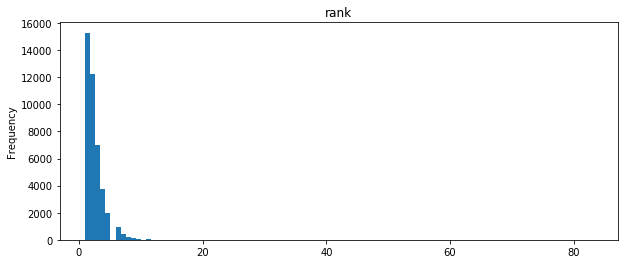

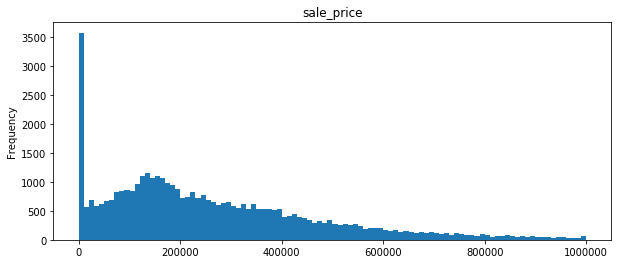

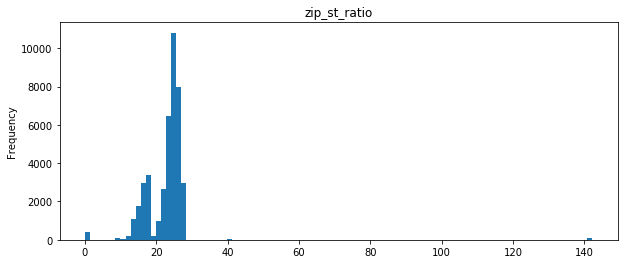

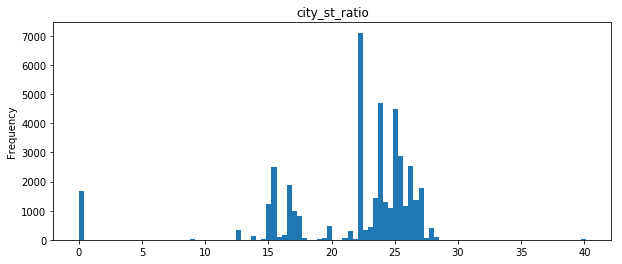

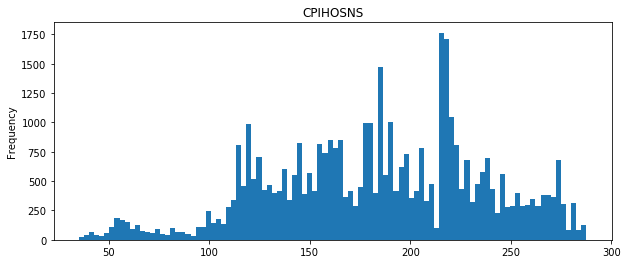

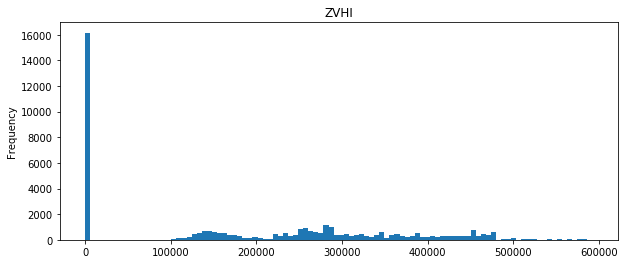

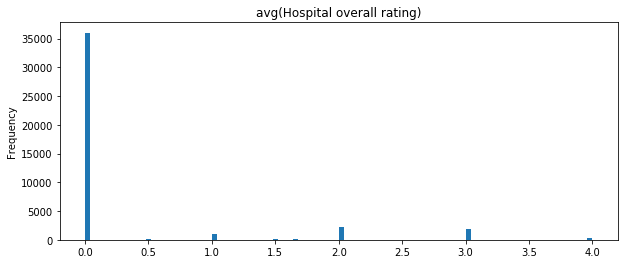

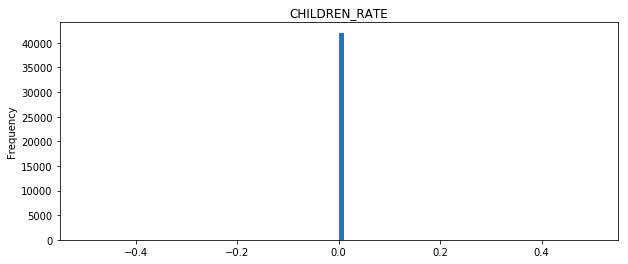

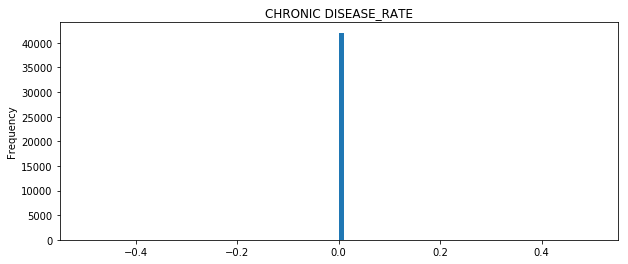

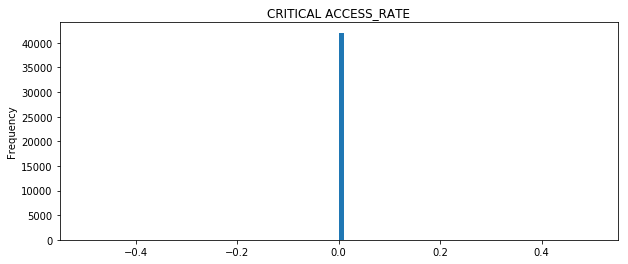

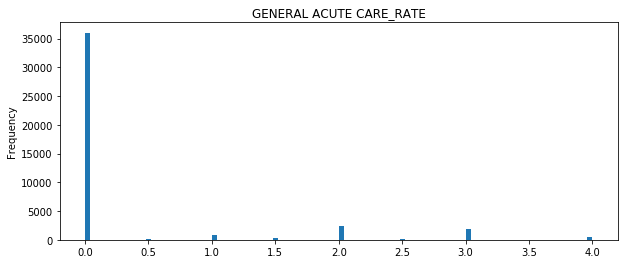

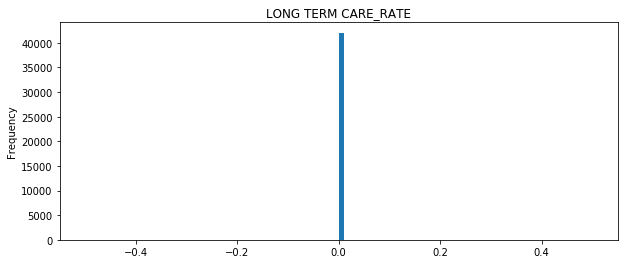

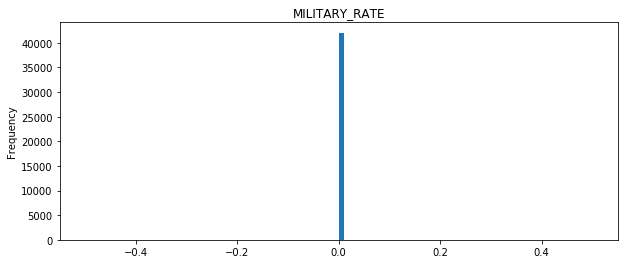

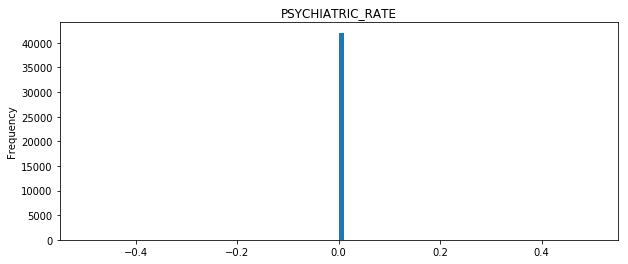

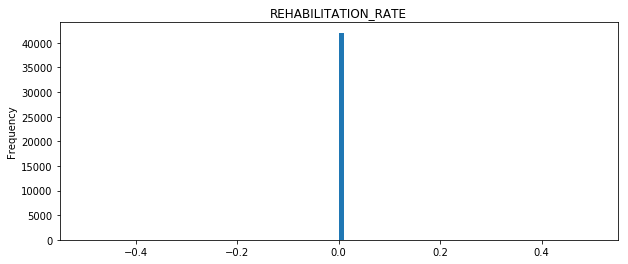

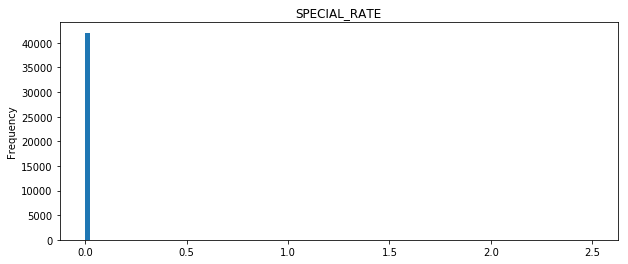

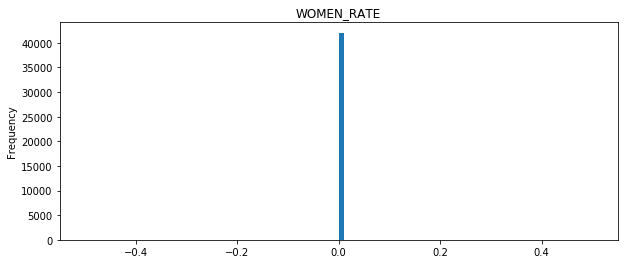

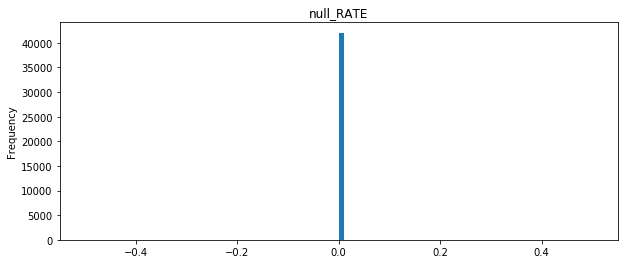

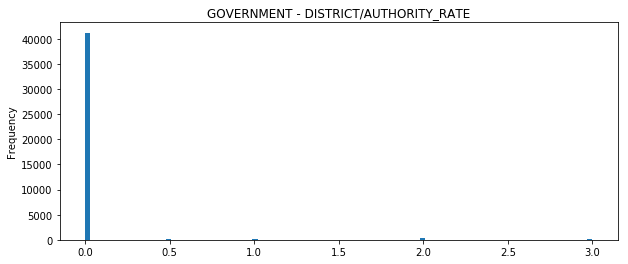

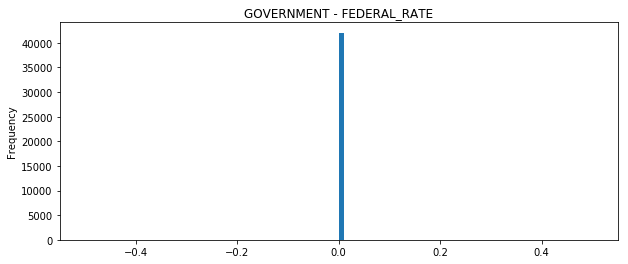

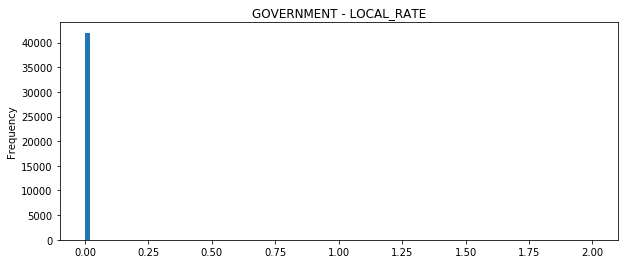

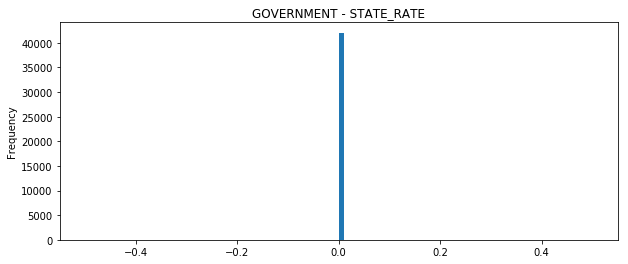

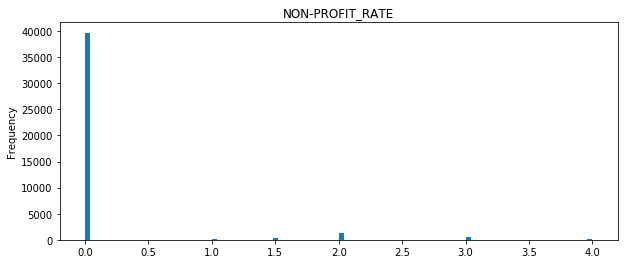

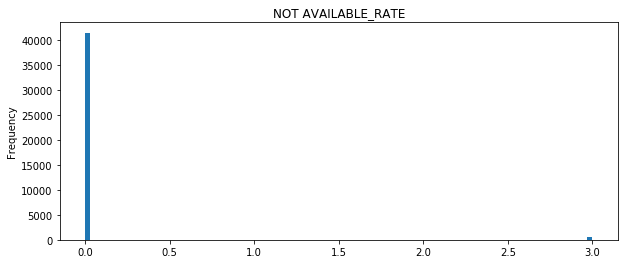

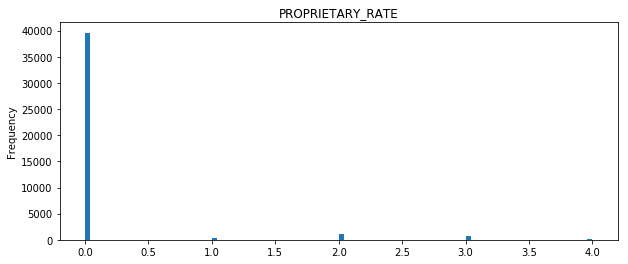

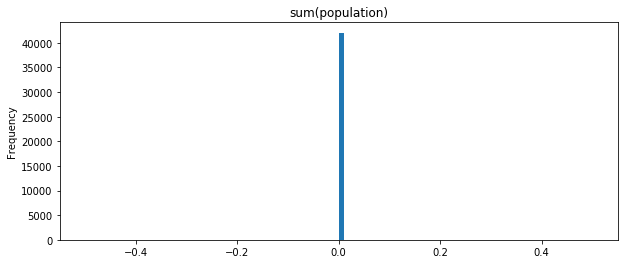

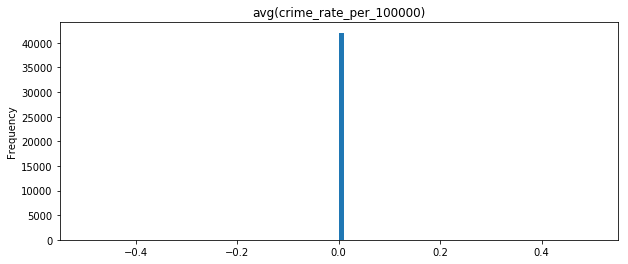

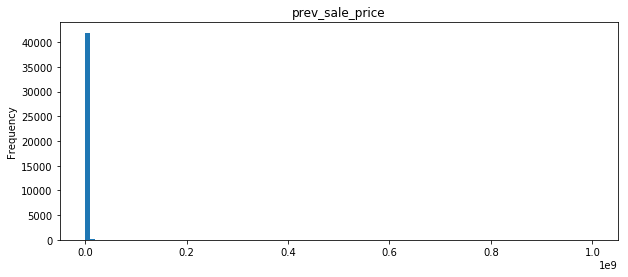

In [119]:
for column in sampled_data.columns:
    plt.figure(figsize=(10,4))
    sampled_data[column].plot(kind='hist', bins=100)
    plt.title(column)

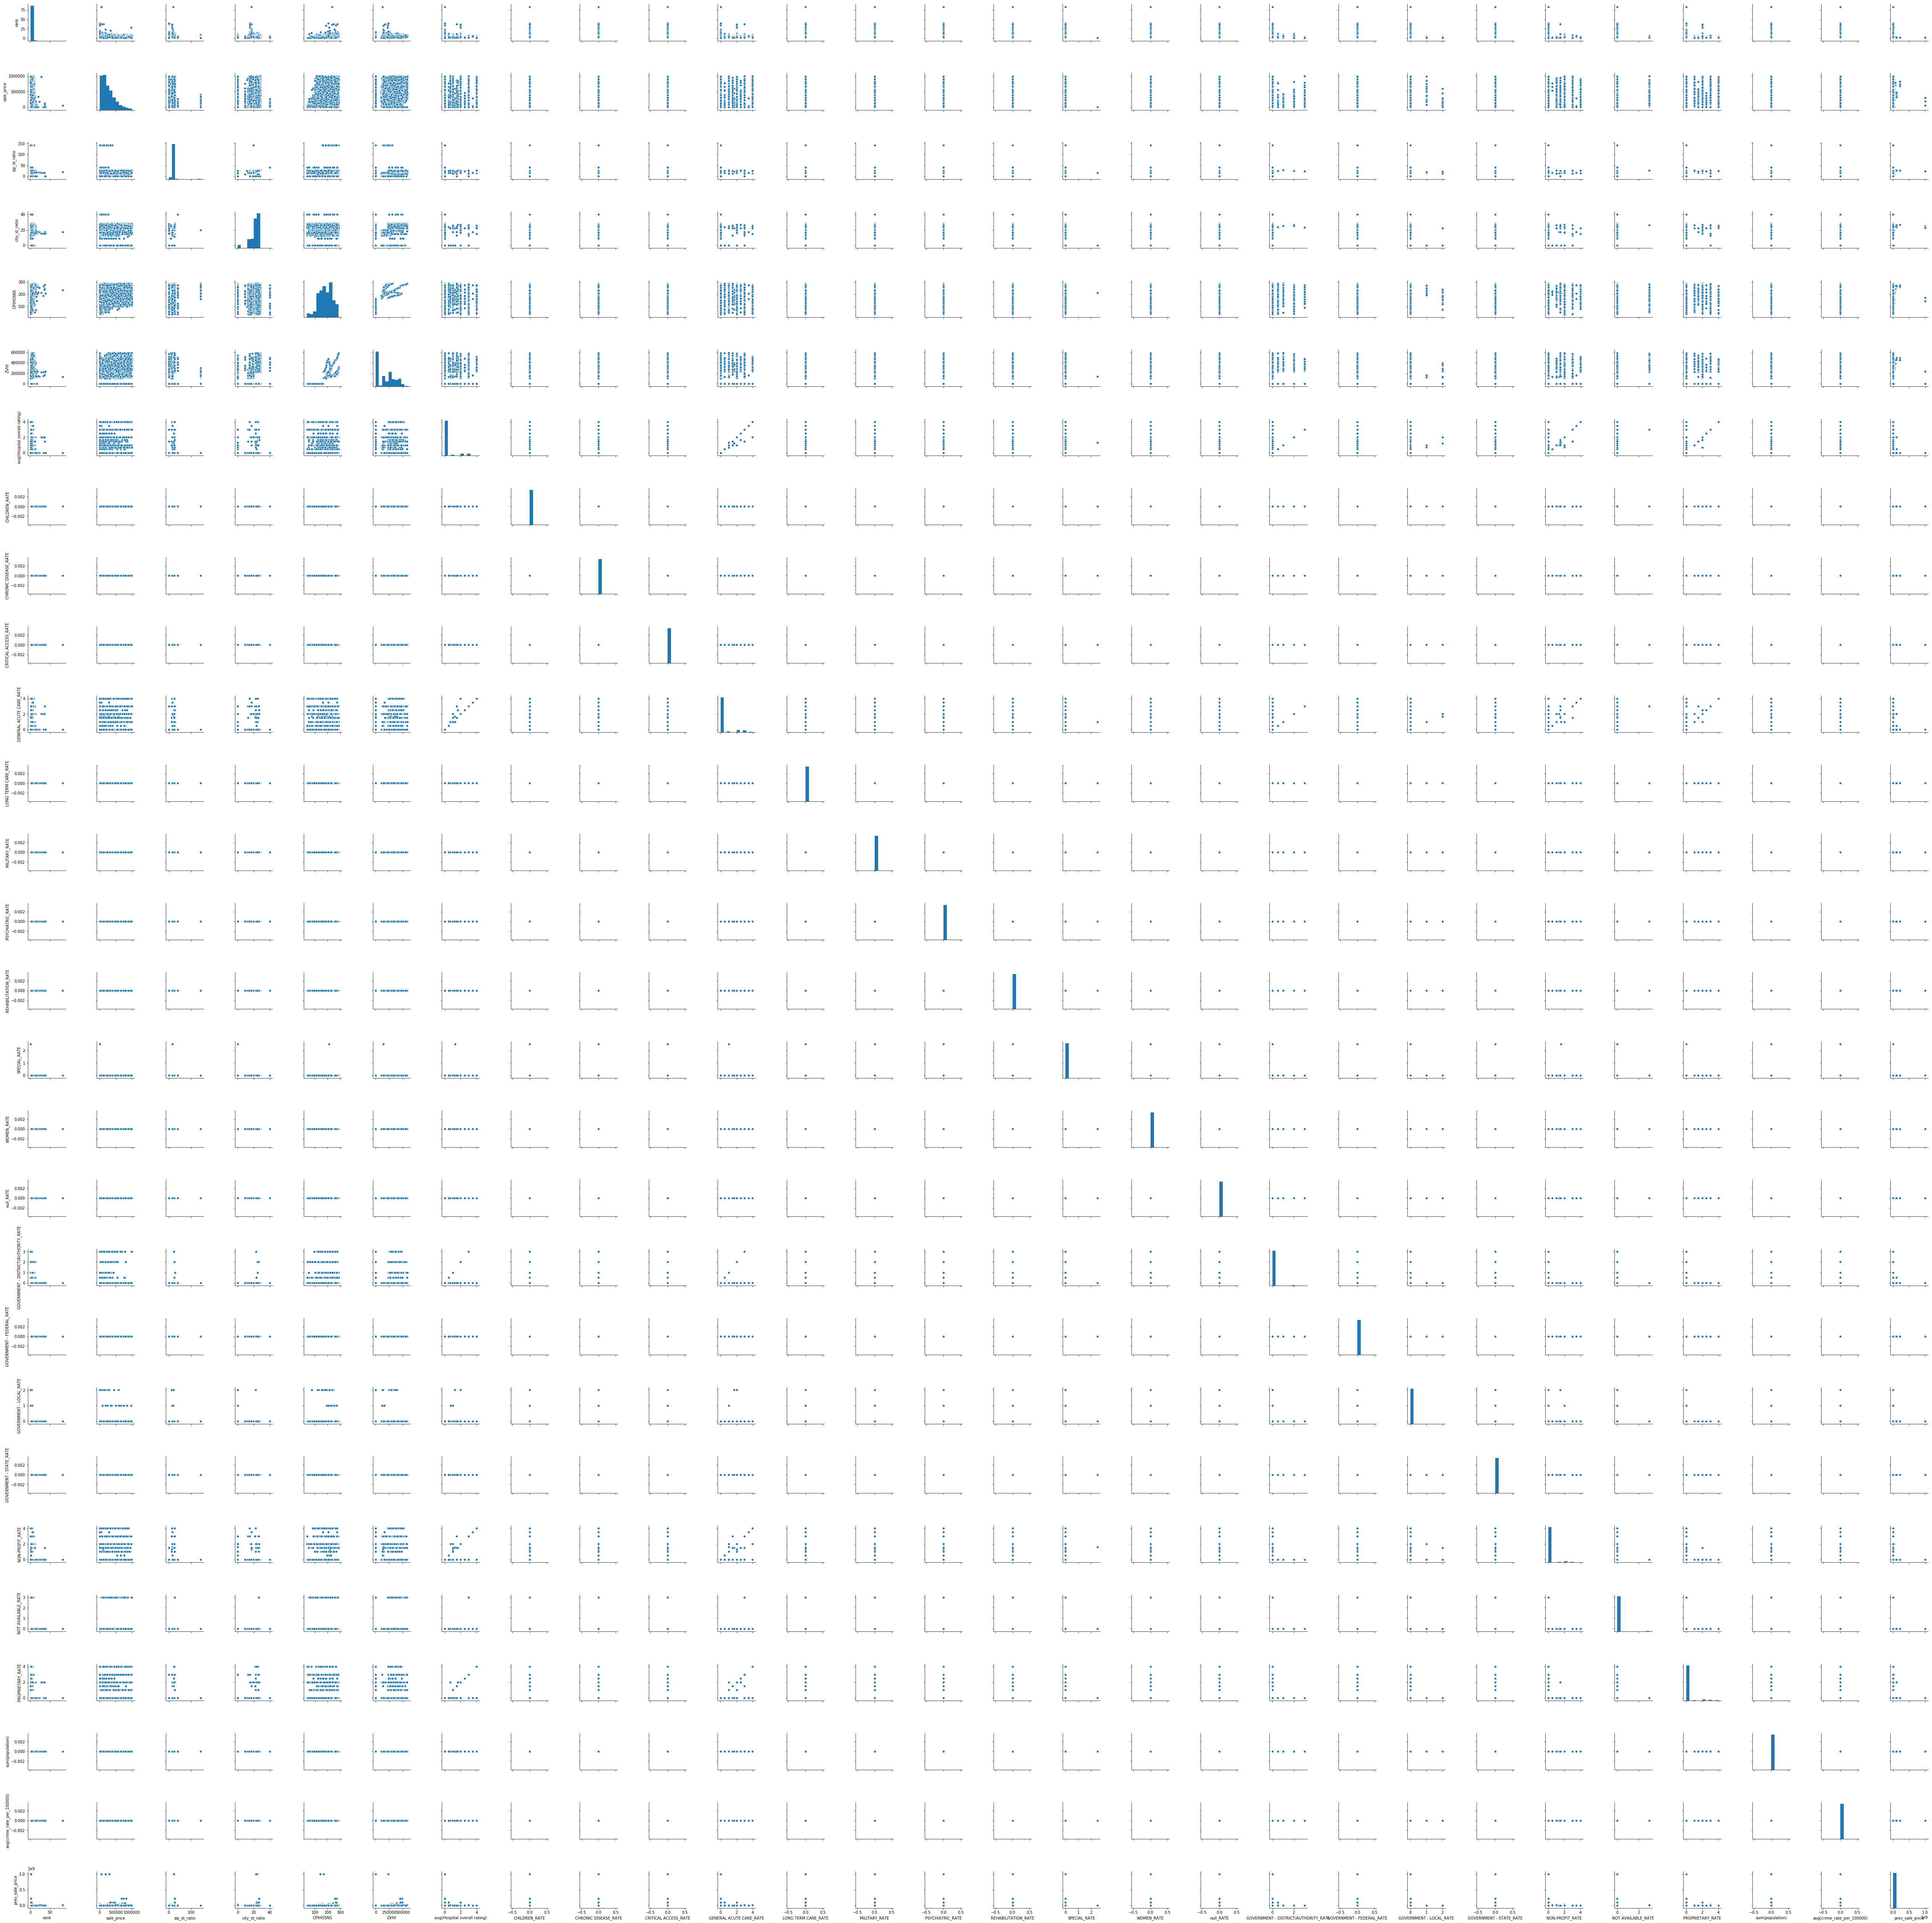

In [120]:
sns.pairplot(sampled_data)

In [122]:
# numerical_columns = sampled_data.columns 
# for column in numerical_columns:
#     plt.figure(figsize=(10,4))
#     bank_df[column].plot(kind='hist', bins=50)
#     plt.title(column)

In [124]:
# import seaborn as sns

# sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
# sns.distplot(
#     housing['SalePrice'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
# ).set(xlabel='Sale Price', ylabel='Count');

In [ ]:
#more feature correlation

In [ ]:
#correlation with y variable (sale_price)
y_corr = pd.DataFrame(columns=['Columns', 'Correlation Value'])
for x in df.columns:
    try:
        print(x)
        temp = pd.DataFrame([[x, df.corr("sale_price", x)]], columns=['Columns', 'Correlation Value'])
        y_corr = y_corr.append(temp)
    except:
        pass
y_corr

In [ ]:
x_vars = []
#all x variable correlation
x_corr = pd.DataFrame({"Variables" : x_vars})
for x in x_vars:
    temp2 = pd.DataFrame()
    for y in x_vars:
        print(str(x) + " and " + str(y))
        try:
            temp = pd.DataFrame([[df.corr(x,y)]], columns=[x])
#             temp = pd.DataFrame([["CORR"]], columns=[x])
            temp2 = temp2.append(temp)
        except:
            temp = pd.DataFrame([["N/A"]], columns=[x])
            temp2 = temp2.append(temp)
    x_corr = pd.concat([x_corr,temp2.reset_index().drop(columns="index")], axis=1)
x_corr

In [ ]:
import seaborn as sns
import numpy as np
# np.array(x_corr)
axis_labels = x_corr['Variables']
sns.heatmap(np.array(x_corr.set_index("Variables")), annot=False, fmt="g",vmin=0, vmax=1,linewidths=.5
           ,xticklabels=axis_labels, yticklabels=axis_labels)

### Y Variable analysis (Regression)

In [125]:
### Aggregated sale count, avg price by sale year
sales_over_time = df.groupBy("sale_year").agg(F.mean(df.sale_price).alias("avg_sale_price"),
                                             F.count(df.sale_price).alias("sale_count")).toPandas()

AnalysisException: "cannot resolve '`sale_year`' given input columns: [GOVERNMENT - STATE_CNT, year_built, count(RAPE), PROPRIETARY_RATE, WOMEN_RATE, count(ROBBERY), Median_Income, zip_num_schools, city_num_schools, GOVERNMENT - LOCAL_RATE, PSYCHIATRIC_RATE, prev_sale_date, count(MVTHEFT), LONG TERM CARE_RATE, CRITICAL ACCESS_CNT, sale_price, CRITICAL ACCESS_RATE, ZVHI, rank, num_units, CHRONIC DISEASE_CNT, WOMEN_CNT, CHILDREN_CNT, avg(Hospital overall rating), num_sales, city, sum(population), MILITARY_RATE, GENERAL ACUTE CARE_CNT, physical_address, avg(crime_rate_per_100000), null_RATE, SPECIAL_RATE, zip_st_ratio, sum(count), GOVERNMENT - FEDERAL_RATE, MILITARY_CNT, sale_date, SPECIAL_CNT, count(ARSON), CPIHOSNS, GOVERNMENT - DISTRICT/AUTHORITY_CNT, REHABILITATION_CNT, NON-PROFIT_CNT, count(MURDER), NOT AVAILABLE_RATE, zip5, null_CNT, city_st_ratio, CHRONIC DISEASE_RATE, property_type, REHABILITATION_RATE, LONG TERM CARE_CNT, GOVERNMENT - STATE_RATE, GOVERNMENT - LOCAL_CNT, prev_sale_price, property_id, count(BURGLRY), PSYCHIATRIC_CNT, GENERAL ACUTE CARE_RATE, PROPRIETARY_CNT, GOVERNMENT - DISTRICT/AUTHORITY_RATE, CHILDREN_RATE, NON-PROFIT_RATE, state, count(AGASSLT), GOVERNMENT - FEDERAL_CNT, NOT AVAILABLE_CNT];;\n'Aggregate ['sale_year], ['sale_year, avg(cast(sale_price#8940 as double)) AS avg_sale_price#13678, count(sale_price#8940) AS sale_count#13680L]\n+- Project [city#13, state#10, physical_address#12, zip5#11, property_type#17, coalesce(rank#8304, cast(0.0 as int)) AS rank#8939, property_id#15, sale_date#1734, coalesce(nanvl(sale_price#7805, cast(null as float)), cast(0.0 as float)) AS sale_price#8940, num_units#21, year_built#22, coalesce(num_sales#7806L, cast(0.0 as bigint)) AS num_sales#8941L, coalesce(zip_num_schools#7807L, cast(0.0 as bigint)) AS zip_num_schools#8942L, coalesce(city_num_schools#7808L, cast(0.0 as bigint)) AS city_num_schools#8943L, coalesce(nanvl(zip_st_ratio#7809, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#8944, coalesce(nanvl(city_st_ratio#7810, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#8945, coalesce(nanvl(CPIHOSNS#7811, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#8946, coalesce(nanvl(ZVHI#7812, cast(null as double)), cast(0.0 as double)) AS ZVHI#8947, coalesce(Median_Income#7813, cast(0.0 as decimal(12,2))) AS Median_Income#8948, coalesce(sum(count)#7814L, cast(0.0 as bigint)) AS sum(count)#8949L, coalesce(nanvl(avg(Hospital overall rating)#7815, cast(null as double)), cast(0.0 as double)) AS avg(Hospital overall rating)#8950, coalesce(CHILDREN_CNT#7816L, cast(0.0 as bigint)) AS CHILDREN_CNT#8951L, coalesce(nanvl(CHILDREN_RATE#7817, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#8952, coalesce(CHRONIC DISEASE_CNT#7818L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#8953L, ... 44 more fields]\n   +- Project [city#13, state#10, physical_address#12, zip5#11, property_type#17, rank#8304, property_id#15, sale_date#1734, sale_price#7805, num_units#21, year_built#22, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, ... 44 more fields]\n      +- Join LeftOuter, ((((((city#13 = city#8778) && (state#10 = state#8775)) && (physical_address#12 = physical_address#8777)) && (zip5#11 = zip5#8776)) && (property_type#17 = property_type#8782)) && (rank#8304 = rank#8666))\n         :- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#7805, num_units#21, year_built#22, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, CHRONIC DISEASE_RATE#7819, ... 42 more fields]\n         :  +- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#7805, num_units#21, year_built#22, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, CHRONIC DISEASE_RATE#7819, ... 43 more fields]\n         :     +- Window [dense_rank(sale_date#1734) windowspecdefinition(city#13, state#10, physical_address#12, zip5#11, property_type#17, sale_date#1734 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS rank#8304], [city#13, state#10, physical_address#12, zip5#11, property_type#17], [sale_date#1734 ASC NULLS FIRST]\n         :        +- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#7805, num_units#21, year_built#22, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, CHRONIC DISEASE_RATE#7819, ... 41 more fields]\n         :           +- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#7288, cast(null as float)), cast(0.0 as float)) AS sale_price#7805, num_units#21, year_built#22, coalesce(num_sales#7289L, cast(0.0 as bigint)) AS num_sales#7806L, coalesce(zip_num_schools#7290L, cast(0.0 as bigint)) AS zip_num_schools#7807L, coalesce(city_num_schools#7291L, cast(0.0 as bigint)) AS city_num_schools#7808L, coalesce(nanvl(zip_st_ratio#7292, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#7809, coalesce(nanvl(city_st_ratio#7293, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#7810, coalesce(nanvl(CPIHOSNS#7294, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#7811, coalesce(nanvl(ZVHI#7295, cast(null as double)), cast(0.0 as double)) AS ZVHI#7812, coalesce(Median_Income#7296, cast(0.0 as decimal(12,2))) AS Median_Income#7813, coalesce(sum(count)#7297L, cast(0.0 as bigint)) AS sum(count)#7814L, coalesce(nanvl(avg(Hospital overall rating)#7298, cast(null as double)), cast(0.0 as double)) AS avg(Hospital overall rating)#7815, coalesce(CHILDREN_CNT#7299L, cast(0.0 as bigint)) AS CHILDREN_CNT#7816L, coalesce(nanvl(CHILDREN_RATE#7300, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#7817, coalesce(CHRONIC DISEASE_CNT#7301L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#7818L, coalesce(nanvl(CHRONIC DISEASE_RATE#7302, cast(null as double)), cast(0.0 as double)) AS CHRONIC DISEASE_RATE#7819, ... 41 more fields]\n         :              +- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#7288, num_units#21, year_built#22, num_sales#7289L, zip_num_schools#7290L, city_num_schools#7291L, zip_st_ratio#7292, city_st_ratio#7293, CPIHOSNS#7294, ZVHI#7295, Median_Income#7296, sum(count)#7297L, avg(Hospital overall rating)#7298, CHILDREN_CNT#7299L, CHILDREN_RATE#7300, CHRONIC DISEASE_CNT#7301L, CHRONIC DISEASE_RATE#7302, ... 41 more fields]\n         :                 +- Join LeftOuter, (state#10 = state#7457)\n         :                    :- Project [zip5#11, state#10, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#6002, cast(null as float)), cast(0.0 as float)) AS sale_price#7288, num_units#21, year_built#22, coalesce(num_sales#6003L, cast(0.0 as bigint)) AS num_sales#7289L, coalesce(zip_num_schools#6004L, cast(0.0 as bigint)) AS zip_num_schools#7290L, coalesce(city_num_schools#6005L, cast(0.0 as bigint)) AS city_num_schools#7291L, coalesce(nanvl(zip_st_ratio#6006, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#7292, coalesce(nanvl(city_st_ratio#6007, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#7293, coalesce(nanvl(CPIHOSNS#6008, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#7294, coalesce(nanvl(ZVHI#6009, cast(null as double)), cast(0.0 as double)) AS ZVHI#7295, coalesce(Median_Income#6267, cast(0.0 as decimal(12,2))) AS Median_Income#7296, coalesce(sum(count)#6493L, cast(0.0 as bigint)) AS sum(count)#7297L, coalesce(nanvl(avg(Hospital overall rating)#6494, cast(null as double)), cast(0.0 as double)) AS avg(Hospital overall rating)#7298, coalesce(CHILDREN_CNT#6633L, cast(0.0 as bigint)) AS CHILDREN_CNT#7299L, coalesce(nanvl(CHILDREN_RATE#6634, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#7300, coalesce(CHRONIC DISEASE_CNT#6635L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#7301L, coalesce(nanvl(CHRONIC DISEASE_RATE#6636, cast(null as double)), cast(0.0 as double)) AS CHRONIC DISEASE_RATE#7302, ... 32 more fields]\n         :                    :  +- Project [zip5#11, state#10, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#6002, num_units#21, year_built#22, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, Median_Income#6267, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, ... 32 more fields]\n         :                    :     +- Join LeftOuter, (zip5#11 = ZIP5#7057)\n         :                    :        :- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#6002, num_units#21, year_built#22, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, cast(regexp_replace(Median_Income#6136, ,, ) as decimal(12,2)) AS Median_Income#6267]\n         :                    :        :  +- Project [state#10, zip5#11, physical_address#12, city#13, property_id#15, sale_date#1734, property_type#17, sale_price#6002, num_units#21, year_built#22, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, Median_Income#6136]\n         :                    :        :     +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#6002, num_units#21, year_built#22, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, Zip#5634, Income#440, CASE WHEN (year(sale_date#1734) < 2011) THEN Income#440 ELSE Households!!Estimate!!Median income (dollars)#191 END AS Median_Income#6136]\n         :                    :        :        +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#4975, cast(null as float)), cast(0.0 as float)) AS sale_price#6002, num_units#21, year_built#22, coalesce(num_sales#4976L, cast(0.0 as bigint)) AS num_sales#6003L, coalesce(zip_num_schools#4977L, cast(0.0 as bigint)) AS zip_num_schools#6004L, coalesce(city_num_schools#4978L, cast(0.0 as bigint)) AS city_num_schools#6005L, coalesce(nanvl(zip_st_ratio#4979, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#6006, coalesce(nanvl(city_st_ratio#4980, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#6007, coalesce(nanvl(CPIHOSNS#4981, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#6008, coalesce(nanvl(ZVHI#4982, cast(null as double)), cast(0.0 as double)) AS ZVHI#6009, Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, Zip#5634, Income#440]\n         :                    :        :           +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4975, num_units#21, year_built#22, num_sales#4976L, zip_num_schools#4977L, city_num_schools#4978L, zip_st_ratio#4979, city_st_ratio#4980, CPIHOSNS#4981, ZVHI#4982, Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, Zip#5634, Income#440]\n         :                    :        :              +- Join LeftOuter, ((year(sale_date#1734) = cast(Year_2000#5836 as int)) && (upper(county#14) = upper(County_2000#5831)))\n         :                    :        :                 :- Join LeftOuter, ((year(sale_date#1734) = cast(Year#166 as int)) && (zip5#11 = Zip#5634))\n         :                    :        :                 :  :- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#4565, cast(null as float)), cast(0.0 as float)) AS sale_price#4975, num_units#21, year_built#22, coalesce(num_sales#4566L, cast(0.0 as bigint)) AS num_sales#4976L, coalesce(zip_num_schools#4567L, cast(0.0 as bigint)) AS zip_num_schools#4977L, coalesce(city_num_schools#4568L, cast(0.0 as bigint)) AS city_num_schools#4978L, coalesce(nanvl(zip_st_ratio#4569, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#4979, coalesce(nanvl(city_st_ratio#4570, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#4980, coalesce(nanvl(CPIHOSNS#129, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#4981, coalesce(nanvl(ZVHI#4858, cast(null as double)), cast(0.0 as double)) AS ZVHI#4982]\n         :                    :        :                 :  :  +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4565, num_units#21, year_built#22, num_sales#4566L, zip_num_schools#4567L, city_num_schools#4568L, zip_st_ratio#4569, city_st_ratio#4570, CPIHOSNS#129, ZVHI#4858]\n         :                    :        :                 :  :     +- Join LeftOuter, (((month(sale_date#1734) = month#4862) && (year(sale_date#1734) = year#4867)) && (state#10 = StateName#147))\n         :                    :        :                 :  :        :- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4565, num_units#21, year_built#22, num_sales#4566L, zip_num_schools#4567L, city_num_schools#4568L, zip_st_ratio#4569, city_st_ratio#4570, CPIHOSNS#129]\n         :                    :        :                 :  :        :  +- Join LeftOuter, ((month(sale_date#1734) = month#4657) && (year(sale_date#1734) = year#4661))\n         :                    :        :                 :  :        :     :- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#4215, cast(null as float)), cast(0.0 as float)) AS sale_price#4565, num_units#21, year_built#22, coalesce(num_sales#4216L, cast(0.0 as bigint)) AS num_sales#4566L, coalesce(zip_num_schools#4217L, cast(0.0 as bigint)) AS zip_num_schools#4567L, coalesce(city_num_schools#4233L, cast(0.0 as bigint)) AS city_num_schools#4568L, coalesce(nanvl(zip_st_ratio#4342, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#4569, coalesce(nanvl(city_st_ratio#4457, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#4570]\n         :                    :        :                 :  :        :     :  +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4215, num_units#21, year_built#22, num_sales#4216L, zip_num_schools#4217L, city_num_schools#4233L, zip_st_ratio#4342, city_st_ratio#4457]\n         :                    :        :                 :  :        :     :     +- Join LeftOuter, ((city#13 = city#58) && (state#10 = state#59))\n         :                    :        :                 :  :        :     :        :- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4215, num_units#21, year_built#22, num_sales#4216L, zip_num_schools#4217L, city_num_schools#4233L, zip_st_ratio#4342]\n         :                    :        :                 :  :        :     :        :  +- Join LeftOuter, (zip5#11 = ZIP#60)\n         :                    :        :                 :  :        :     :        :     :- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4215, num_units#21, year_built#22, num_sales#4216L, zip_num_schools#4217L, count#4218L AS city_num_schools#4233L]\n         :                    :        :                 :  :        :     :        :     :  +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#4017, cast(null as float)), cast(0.0 as float)) AS sale_price#4215, num_units#21, year_built#22, coalesce(num_sales#4018L, cast(0.0 as bigint)) AS num_sales#4216L, coalesce(zip_num_schools#4033L, cast(0.0 as bigint)) AS zip_num_schools#4217L, coalesce(count#4135L, cast(0.0 as bigint)) AS count#4218L]\n         :                    :        :                 :  :        :     :        :     :     +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4017, num_units#21, year_built#22, num_sales#4018L, zip_num_schools#4033L, count#4135L]\n         :                    :        :                 :  :        :     :        :     :        +- Join LeftOuter, ((city#13 = city#58) && (state#10 = state#59))\n         :                    :        :                 :  :        :     :        :     :           :- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#4017, num_units#21, year_built#22, num_sales#4018L, count#4019L AS zip_num_schools#4033L]\n         :                    :        :                 :  :        :     :        :     :           :  +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, coalesce(nanvl(sale_price#1748, cast(null as float)), cast(0.0 as float)) AS sale_price#4017, num_units#21, year_built#22, coalesce(num_sales#1981L, cast(0.0 as bigint)) AS num_sales#4018L, coalesce(count#3946L, cast(0.0 as bigint)) AS count#4019L]\n         :                    :        :                 :  :        :     :        :     :           :     +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#1748, num_units#21, year_built#22, num_sales#1981L, count#3946L]\n         :                    :        :                 :  :        :     :        :     :           :        +- Join LeftOuter, (zip5#11 = ZIP#60)\n         :                    :        :                 :  :        :     :        :     :           :           :- Filter (num_sales#1981L > cast(1 as bigint))\n         :                    :        :                 :  :        :     :        :     :           :           :  +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#1748, num_units#21, year_built#22, num_sales#1981L]\n         :                    :        :                 :  :        :     :        :     :           :           :     +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#1748, num_units#21, year_built#22, num_sales#1981L, num_sales#1981L]\n         :                    :        :                 :  :        :     :        :     :           :           :        +- Window [count(city#13) windowspecdefinition(city#13, state#10, physical_address#12, zip5#11, specifiedwindowframe(RangeFrame, unboundedpreceding$(), unboundedfollowing$())) AS num_sales#1981L], [city#13, state#10, physical_address#12, zip5#11]\n         :                    :        :                 :  :        :     :        :     :           :           :           +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, sale_price#1748, num_units#21, year_built#22]\n         :                    :        :                 :  :        :     :        :     :           :           :              +- Filter NOT property_type#17 LIKE %RENTALS%\n         :                    :        :                 :  :        :     :        :     :           :           :                 +- Filter NOT property_type#17 LIKE %MOBILE%HOME%\n         :                    :        :                 :  :        :     :        :     :           :           :                    +- Filter NOT property_type#17 LIKE %CONDO%\n         :                    :        :                 :  :        :     :        :     :           :           :                       +- Filter (cast(num_units#21 as int) = 1)\n         :                    :        :                 :  :        :     :        :     :           :           :                          +- Filter (((isnotnull(city#13) && isnotnull(state#10)) && isnotnull(physical_address#12)) && isnotnull(zip5#11))\n         :                    :        :                 :  :        :     :        :     :           :           :                             +- Filter (sale_price#1748 > cast(0 as float))\n         :                    :        :                 :  :        :     :        :     :           :           :                                +- Filter isnotnull(sale_price#1748)\n         :                    :        :                 :  :        :     :        :     :           :           :                                   +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#1734, property_type#17, cast(sale_price#18 as float) AS sale_price#1748, num_units#21, year_built#22]\n         :                    :        :                 :  :        :     :        :     :           :           :                                      +- Filter ((year(sale_date#1734) <= 2021) && (year(sale_date#1734) >= 1970))\n         :                    :        :                 :  :        :     :        :     :           :           :                                         +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, to_date(cast(unix_timestamp('sale_date, yyyy-MM-dd, None) as timestamp), None) AS sale_date#1734, property_type#17, sale_price#18, num_units#21, year_built#22]\n         :                    :        :                 :  :        :     :        :     :           :           :                                            +- Project [state#10, zip5#11, physical_address#12, city#13, county#14, property_id#15, sale_date#16, property_type#17, sale_price#18, num_units#21, year_built#22]\n         :                    :        :                 :  :        :     :        :     :           :           :                                               +- Relation[state#10,zip5#11,physical_address#12,city#13,county#14,property_id#15,sale_date#16,property_type#17,sale_price#18,seller_name#19,buyer_name#20,num_units#21,year_built#22,source_url#23,book#24,page#25] csv\n         :                    :        :                 :  :        :     :        :     :           :           +- Aggregate [ZIP#60], [ZIP#60, count(1) AS count#3946L]\n         :                    :        :                 :  :        :     :        :     :           :              +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n         :                    :        :                 :  :        :     :        :     :           +- Aggregate [city#58, state#59], [city#58, state#59, count(1) AS count#4135L]\n         :                    :        :                 :  :        :     :        :     :              +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n         :                    :        :                 :  :        :     :        :     +- Aggregate [ZIP#60], [ZIP#60, (cast(sum(cast(ENROLLMENT#79 as bigint)) as double) / cast(sum(cast(FT_TEACHER#83 as bigint)) as double)) AS zip_st_ratio#4342]\n         :                    :        :                 :  :        :     :        :        +- Filter (NOT (ENROLLMENT#79 = -1) && NOT (FT_TEACHER#83 = -1))\n         :                    :        :                 :  :        :     :        :           +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n         :                    :        :                 :  :        :     :        +- Aggregate [city#58, state#59], [city#58, state#59, (cast(sum(cast(ENROLLMENT#79 as bigint)) as double) / cast(sum(cast(FT_TEACHER#83 as bigint)) as double)) AS city_st_ratio#4457]\n         :                    :        :                 :  :        :     :           +- Filter (NOT (ENROLLMENT#79 = -1) && NOT (FT_TEACHER#83 = -1))\n         :                    :        :                 :  :        :     :              +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n         :                    :        :                 :  :        :     +- Project [DATE#128, CPIHOSNS#129, month#4657, year(cast(DATE#128 as date)) AS year#4661]\n         :                    :        :                 :  :        :        +- Project [DATE#128, CPIHOSNS#129, month(cast(DATE#128 as date)) AS month#4657]\n         :                    :        :                 :  :        :           +- Relation[DATE#128,CPIHOSNS#129] csv\n         :                    :        :                 :  :        +- Project [StateName#147, Date#4840, ZVHI#4858, month#4862, year(DATE#4840) AS year#4867]\n         :                    :        :                 :  :           +- Project [StateName#147, Date#4840, ZVHI#4858, month(DATE#4840) AS month#4862]\n         :                    :        :                 :  :              +- Sort [StateName#147 ASC NULLS FIRST, Date#4840 ASC NULLS FIRST], true\n         :                    :        :                 :  :                 +- Aggregate [StateName#147, Date#4840], [StateName#147, Date#4840, avg(cast(ZVHI#148 as bigint)) AS ZVHI#4858]\n         :                    :        :                 :  :                    +- Filter ((RegionType#146 = Msa) && (ZVHI#148 > 0))\n         :                    :        :                 :  :                       +- Project [to_date(cast(unix_timestamp('Date, MM/dd/yyyy, None) as timestamp), None) AS Date#4840, RegionID#143, SizeRank#144, RegionName#145, RegionType#146, StateName#147, ZVHI#148]\n         :                    :        :                 :  :                          +- Relation[Date#142,RegionID#143,SizeRank#144,RegionName#145,RegionType#146,StateName#147,ZVHI#148] csv\n         :                    :        :                 :  +- Project [Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, substring(Geographic Area Name#168, -5, 5) AS Zip#5634]\n         :                    :        :                 :     +- Project [Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191]\n         :                    :        :                 :        +- Relation[Year#166,id#167,Geographic Area Name#168,Households!!Estimate!!Total#169,Households!!Margin of Error!!Total#170,Households!!Estimate!!Less than $10,000#171,Households!!Margin of Error!!Less than $10,000#172,Households!!Estimate!!$10,000 to $14,999#173,Households!!Margin of Error!!$10,000 to $14,999#174,Households!!Estimate!!$15,000 to $24,999#175,Households!!Margin of Error!!$15,000 to $24,999#176,Households!!Estimate!!$25,000 to $34,999#177,Households!!Margin of Error!!$25,000 to $34,999#178,Households!!Estimate!!$35,000 to $49,999#179,Households!!Margin of Error!!$35,000 to $49,999#180,Households!!Estimate!!$50,000 to $74,999#181,Households!!Margin of Error!!$50,000 to $74,999#182,Households!!Estimate!!$75,000 to $99,999#183,Households!!Margin of Error!!$75,000 to $99,999#184,Households!!Estimate!!$100,000 to $149,999#185,Households!!Margin of Error!!$100,000 to $149,999#186,Households!!Estimate!!$150,000 to $199,999#187,Households!!Margin of Error!!$150,000 to $199,999#188,Households!!Estimate!!$200,000 or more#189,... 107 more fields] csv\n         :                    :        :                 +- Project [Region#438, Year#439 AS Year_2000#5836, Income#440, County_2000#5831]\n         :                    :        :                    +- Project [Region#438, Year#439, Income#440, upper(substring_index(Region#438,  County, 1)) AS County_2000#5831]\n         :                    :        :                       +- Filter Contains(Region#438, County)\n         :                    :        :                          +- Relation[Region#438,Year#439,Income#440] csv\n         :                    :        +- Project [sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652, null_CNT#6797L, null_RATE#6798, ... 15 more fields]\n         :                    :           +- Project [ZIP#528, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652, null_CNT#6797L, ... 16 more fields]\n         :                    :              +- Project [ZIP#528, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652, null_CNT#6797L, ... 15 more fields]\n         :                    :                 +- Join LeftOuter, (ZIP#528 = ZIP#6956)\n         :                    :                    :- Project [ZIP#528, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652]\n         :                    :                    :  +- Join LeftOuter, (ZIP#528 = ZIP#6859)\n         :                    :                    :     :- Sort [sum(count)#6493L DESC NULLS LAST], true\n         :                    :                    :     :  +- Aggregate [ZIP#528], [ZIP#528, sum(count#6472L) AS sum(count)#6493L, avg(cast(Hospital overall rating#6398 as double)) AS avg(Hospital overall rating)#6494]\n         :                    :                    :     :     +- Sort [count#6472L DESC NULLS LAST], true\n         :                    :                    :     :        +- Aggregate [ZIP#528, CITY#526, STATE#527, COUNTY#534, TYPE#531, Hospital overall rating#6398, OWNER#549, STATUS#532], [ZIP#528, CITY#526, STATE#527, COUNTY#534, TYPE#531, Hospital overall rating#6398, OWNER#549, STATUS#532, count(1) AS count#6472L]\n         :                    :                    :     :           +- Project [Hospital Name#6290, X#520, Y#521, OBJECTID#522, ID#523, NAME#524, ADDRESS#525, CITY#526, STATE#527, ZIP#528, ZIP4#529, TELEPHONE#530, TYPE#531, STATUS#532, POPULATION#533, COUNTY#534, COUNTYFIPS#535, COUNTRY#536, LATITUDE#537, LONGITUDE#538, NAICS_CODE#539, NAICS_DESC#540, SOURCE#541, SOURCEDATE#542, ... 12 more fields]\n         :                    :                    :     :              +- Project [Hospital Name#6290, X#520, Y#521, OBJECTID#522, ID#523, NAME#524, ADDRESS#525, CITY#526, STATE#527, ZIP#528, ZIP4#529, TELEPHONE#530, TYPE#531, STATUS#532, POPULATION#533, COUNTY#534, COUNTYFIPS#535, COUNTRY#536, LATITUDE#537, LONGITUDE#538, NAICS_CODE#539, NAICS_DESC#540, SOURCE#541, SOURCEDATE#542, ... 12 more fields]\n         :                    :                    :     :                 +- Join LeftOuter, (Hospital Name#6290 = Hospital Name#455)\n         :                    :                    :     :                    :- Project [X#520, Y#521, OBJECTID#522, ID#523, NAME#524, ADDRESS#525, CITY#526, STATE#527, ZIP#528, ZIP4#529, TELEPHONE#530, TYPE#531, STATUS#532, POPULATION#533, COUNTY#534, COUNTYFIPS#535, COUNTRY#536, LATITUDE#537, LONGITUDE#538, NAICS_CODE#539, NAICS_DESC#540, SOURCE#541, SOURCEDATE#542, VAL_METHOD#543, ... 11 more fields]\n         :                    :                    :     :                    :  +- Relation[X#520,Y#521,OBJECTID#522,ID#523,NAME#524,ADDRESS#525,CITY#526,STATE#527,ZIP#528,ZIP4#529,TELEPHONE#530,TYPE#531,STATUS#532,POPULATION#533,COUNTY#534,COUNTYFIPS#535,COUNTRY#536,LATITUDE#537,LONGITUDE#538,NAICS_CODE#539,NAICS_DESC#540,SOURCE#541,SOURCEDATE#542,VAL_METHOD#543,... 10 more fields] csv\n         :                    :                    :     :                    +- Filter NOT (Hospital overall rating#466 = Not Available)\n         :                    :                    :     :                       +- Filter AtLeastNNulls(n, Hospital Name#455,Hospital overall rating#466)\n         :                    :                    :     :                          +- Project [Hospital Name#455, Hospital overall rating#466]\n         :                    :                    :     :                             +- Relation[Provider ID#454,Hospital Name#455,Address#456,City#457,State#458,ZIP Code#459,County Name#460,Phone Number#461,Hospital Type#462,Hospital Ownership#463,Emergency Services#464,Meets criteria for meaningful use of EHRs#465,Hospital overall rating#466,Hospital overall rating footnote#467,Mortality national comparison#468,Mortality national comparison footnote#469,Safety of care national comparison#470,Safety of care national comparison footnote#471,Readmission national comparison#472,Readmission national comparison footnote#473,Patient experience national comparison#474,Patient experience national comparison footnote#475,Effectiveness of care national comparison#476,Effectiveness of care national comparison footnote#477,... 4 more fields] csv\n         :                    :                    :     +- Project [ZIP#6859, coalesce(CHILDREN_CNT#6571L, cast(0.0 as bigint)) AS CHILDREN_CNT#6633L, coalesce(nanvl(CHILDREN_RATE#6572, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#6634, coalesce(CHRONIC DISEASE_CNT#6573L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#6635L, coalesce(nanvl(CHRONIC DISEASE_RATE#6574, cast(null as double)), cast(0.0 as double)) AS CHRONIC DISEASE_RATE#6636, coalesce(CRITICAL ACCESS_CNT#6575L, cast(0.0 as bigint)) AS CRITICAL ACCESS_CNT#6637L, coalesce(nanvl(CRITICAL ACCESS_RATE#6576, cast(null as double)), cast(0.0 as double)) AS CRITICAL ACCESS_RATE#6638, coalesce(GENERAL ACUTE CARE_CNT#6577L, cast(0.0 as bigint)) AS GENERAL ACUTE CARE_CNT#6639L, coalesce(nanvl(GENERAL ACUTE CARE_RATE#6578, cast(null as double)), cast(0.0 as double)) AS GENERAL ACUTE CARE_RATE#6640, coalesce(LONG TERM CARE_CNT#6579L, cast(0.0 as bigint)) AS LONG TERM CARE_CNT#6641L, coalesce(nanvl(LONG TERM CARE_RATE#6580, cast(null as double)), cast(0.0 as double)) AS LONG TERM CARE_RATE#6642, coalesce(MILITARY_CNT#6581L, cast(0.0 as bigint)) AS MILITARY_CNT#6643L, coalesce(nanvl(MILITARY_RATE#6582, cast(null as double)), cast(0.0 as double)) AS MILITARY_RATE#6644, coalesce(PSYCHIATRIC_CNT#6583L, cast(0.0 as bigint)) AS PSYCHIATRIC_CNT#6645L, coalesce(nanvl(PSYCHIATRIC_RATE#6584, cast(null as double)), cast(0.0 as double)) AS PSYCHIATRIC_RATE#6646, coalesce(REHABILITATION_CNT#6585L, cast(0.0 as bigint)) AS REHABILITATION_CNT#6647L, coalesce(nanvl(REHABILITATION_RATE#6586, cast(null as double)), cast(0.0 as double)) AS REHABILITATION_RATE#6648, coalesce(SPECIAL_CNT#6587L, cast(0.0 as bigint)) AS SPECIAL_CNT#6649L, coalesce(nanvl(SPECIAL_RATE#6588, cast(null as double)), cast(0.0 as double)) AS SPECIAL_RATE#6650, coalesce(WOMEN_CNT#6589L, cast(0.0 as bigint)) AS WOMEN_CNT#6651L, coalesce(nanvl(WOMEN_RATE#6590, cast(null as double)), cast(0.0 as double)) AS WOMEN_RATE#6652]\n         :                    :                    :        +- Project [ZIP#6859, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[0] AS CHILDREN_CNT#6571L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[0] AS CHILDREN_RATE#6572, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[1] AS CHRONIC DISEASE_CNT#6573L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[1] AS CHRONIC DISEASE_RATE#6574, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[2] AS CRITICAL ACCESS_CNT#6575L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[2] AS CRITICAL ACCESS_RATE#6576, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[3] AS GENERAL ACUTE CARE_CNT#6577L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[3] AS GENERAL ACUTE CARE_RATE#6578, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[4] AS LONG TERM CARE_CNT#6579L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[4] AS LONG TERM CARE_RATE#6580, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[5] AS MILITARY_CNT#6581L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[5] AS MILITARY_RATE#6582, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[6] AS PSYCHIATRIC_CNT#6583L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[6] AS PSYCHIATRIC_RATE#6584, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[7] AS REHABILITATION_CNT#6585L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[7] AS REHABILITATION_RATE#6586, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[8] AS SPECIAL_CNT#6587L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[8] AS SPECIAL_RATE#6588, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[9] AS WOMEN_CNT#6589L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[9] AS WOMEN_RATE#6590]\n         :                    :                    :           +- Aggregate [ZIP#6859], [ZIP#6859, pivotfirst(TYPE#6862, sum(`count`) AS `CNT`#6525L, CHILDREN, CHRONIC DISEASE, CRITICAL ACCESS, GENERAL ACUTE CARE, LONG TERM CARE, MILITARY, PSYCHIATRIC, REHABILITATION, SPECIAL, WOMEN, 0, 0) AS __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548, pivotfirst(TYPE#6862, avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6526, CHILDREN, CHRONIC DISEASE, CRITICAL ACCESS, GENERAL ACUTE CARE, LONG TERM CARE, MILITARY, PSYCHIATRIC, REHABILITATION, SPECIAL, WOMEN, 0, 0) AS __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570]\n         :                    :                    :              +- Aggregate [ZIP#6859, TYPE#6862], [ZIP#6859, TYPE#6862, sum(count#6472L) AS sum(`count`) AS `CNT`#6525L, avg(cast(Hospital overall rating#6398 as double)) AS avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6526]\n         :                    :                    :                 +- Sort [count#6472L DESC NULLS LAST], true\n         :                    :                    :                    +- Aggregate [ZIP#6859, CITY#6857, STATE#6858, COUNTY#6865, TYPE#6862, Hospital overall rating#6398, OWNER#6880, STATUS#6863], [ZIP#6859, CITY#6857, STATE#6858, COUNTY#6865, TYPE#6862, Hospital overall rating#6398, OWNER#6880, STATUS#6863, count(1) AS count#6472L]\n         :                    :                    :                       +- Project [Hospital Name#6290, X#6851, Y#6852, OBJECTID#6853, ID#6854, NAME#6855, ADDRESS#6856, CITY#6857, STATE#6858, ZIP#6859, ZIP4#6860, TELEPHONE#6861, TYPE#6862, STATUS#6863, POPULATION#6864, COUNTY#6865, COUNTYFIPS#6866, COUNTRY#6867, LATITUDE#6868, LONGITUDE#6869, NAICS_CODE#6870, NAICS_DESC#6871, SOURCE#6872, SOURCEDATE#6873, ... 12 more fields]\n         :                    :                    :                          +- Project [Hospital Name#6290, X#6851, Y#6852, OBJECTID#6853, ID#6854, NAME#6855, ADDRESS#6856, CITY#6857, STATE#6858, ZIP#6859, ZIP4#6860, TELEPHONE#6861, TYPE#6862, STATUS#6863, POPULATION#6864, COUNTY#6865, COUNTYFIPS#6866, COUNTRY#6867, LATITUDE#6868, LONGITUDE#6869, NAICS_CODE#6870, NAICS_DESC#6871, SOURCE#6872, SOURCEDATE#6873, ... 12 more fields]\n         :                    :                    :                             +- Join LeftOuter, (Hospital Name#6290 = Hospital Name#455)\n         :                    :                    :                                :- Project [X#6851, Y#6852, OBJECTID#6853, ID#6854, NAME#6855, ADDRESS#6856, CITY#6857, STATE#6858, ZIP#6859, ZIP4#6860, TELEPHONE#6861, TYPE#6862, STATUS#6863, POPULATION#6864, COUNTY#6865, COUNTYFIPS#6866, COUNTRY#6867, LATITUDE#6868, LONGITUDE#6869, NAICS_CODE#6870, NAICS_DESC#6871, SOURCE#6872, SOURCEDATE#6873, VAL_METHOD#6874, ... 11 more fields]\n         :                    :                    :                                :  +- Relation[X#6851,Y#6852,OBJECTID#6853,ID#6854,NAME#6855,ADDRESS#6856,CITY#6857,STATE#6858,ZIP#6859,ZIP4#6860,TELEPHONE#6861,TYPE#6862,STATUS#6863,POPULATION#6864,COUNTY#6865,COUNTYFIPS#6866,COUNTRY#6867,LATITUDE#6868,LONGITUDE#6869,NAICS_CODE#6870,NAICS_DESC#6871,SOURCE#6872,SOURCEDATE#6873,VAL_METHOD#6874,... 10 more fields] csv\n         :                    :                    :                                +- Filter NOT (Hospital overall rating#466 = Not Available)\n         :                    :                    :                                   +- Filter AtLeastNNulls(n, Hospital Name#455,Hospital overall rating#466)\n         :                    :                    :                                      +- Project [Hospital Name#455, Hospital overall rating#466]\n         :                    :                    :                                         +- Relation[Provider ID#454,Hospital Name#455,Address#456,City#457,State#458,ZIP Code#459,County Name#460,Phone Number#461,Hospital Type#462,Hospital Ownership#463,Emergency Services#464,Meets criteria for meaningful use of EHRs#465,Hospital overall rating#466,Hospital overall rating footnote#467,Mortality national comparison#468,Mortality national comparison footnote#469,Safety of care national comparison#470,Safety of care national comparison footnote#471,Readmission national comparison#472,Readmission national comparison footnote#473,Patient experience national comparison#474,Patient experience national comparison footnote#475,Effectiveness of care national comparison#476,Effectiveness of care national comparison footnote#477,... 4 more fields] csv\n         :                    :                    +- Project [ZIP#6956, null_CNT#6797L, null_RATE#6798, GOVERNMENT - DISTRICT/AUTHORITY_CNT#6799L, GOVERNMENT - DISTRICT/AUTHORITY_RATE#6800, GOVERNMENT - FEDERAL_CNT#6801L, GOVERNMENT - FEDERAL_RATE#6802, GOVERNMENT - LOCAL_CNT#6803L, GOVERNMENT - LOCAL_RATE#6804, GOVERNMENT - STATE_CNT#6805L, GOVERNMENT - STATE_RATE#6806, NON-PROFIT_CNT#6807L, NON-PROFIT_RATE#6808, NOT AVAILABLE_CNT#6809L, NOT AVAILABLE_RATE#6810, PROPRIETARY_CNT#6811L, PROPRIETARY_RATE#6812]\n         :                    :                       +- Project [ZIP#6956, coalesce(null_CNT#6741L, cast(0.0 as bigint)) AS null_CNT#6797L, coalesce(nanvl(null_RATE#6742, cast(null as double)), cast(0.0 as double)) AS null_RATE#6798, coalesce(GOVERNMENT - DISTRICT/AUTHORITY_CNT#6743L, cast(0.0 as bigint)) AS GOVERNMENT - DISTRICT/AUTHORITY_CNT#6799L, coalesce(nanvl(GOVERNMENT - DISTRICT/AUTHORITY_RATE#6744, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - DISTRICT/AUTHORITY_RATE#6800, coalesce(GOVERNMENT - FEDERAL_CNT#6745L, cast(0.0 as bigint)) AS GOVERNMENT - FEDERAL_CNT#6801L, coalesce(nanvl(GOVERNMENT - FEDERAL_RATE#6746, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - FEDERAL_RATE#6802, coalesce(GOVERNMENT - LOCAL_CNT#6747L, cast(0.0 as bigint)) AS GOVERNMENT - LOCAL_CNT#6803L, coalesce(nanvl(GOVERNMENT - LOCAL_RATE#6748, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - LOCAL_RATE#6804, coalesce(GOVERNMENT - STATE_CNT#6749L, cast(0.0 as bigint)) AS GOVERNMENT - STATE_CNT#6805L, coalesce(nanvl(GOVERNMENT - STATE_RATE#6750, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - STATE_RATE#6806, coalesce(NON-PROFIT_CNT#6751L, cast(0.0 as bigint)) AS NON-PROFIT_CNT#6807L, coalesce(nanvl(NON-PROFIT_RATE#6752, cast(null as double)), cast(0.0 as double)) AS NON-PROFIT_RATE#6808, coalesce(NOT AVAILABLE_CNT#6753L, cast(0.0 as bigint)) AS NOT AVAILABLE_CNT#6809L, coalesce(nanvl(NOT AVAILABLE_RATE#6754, cast(null as double)), cast(0.0 as double)) AS NOT AVAILABLE_RATE#6810, coalesce(PROPRIETARY_CNT#6755L, cast(0.0 as bigint)) AS PROPRIETARY_CNT#6811L, coalesce(nanvl(PROPRIETARY_RATE#6756, cast(null as double)), cast(0.0 as double)) AS PROPRIETARY_RATE#6812, coalesce(REHABILITATION_CNT#6757L, cast(0.0 as bigint)) AS REHABILITATION_CNT#6813L, coalesce(nanvl(REHABILITATION_RATE#6758, cast(null as double)), cast(0.0 as double)) AS REHABILITATION_RATE#6814]\n         :                    :                          +- Project [ZIP#6956, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[0] AS null_CNT#6741L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[0] AS null_RATE#6742, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[1] AS GOVERNMENT - DISTRICT/AUTHORITY_CNT#6743L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[1] AS GOVERNMENT - DISTRICT/AUTHORITY_RATE#6744, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[2] AS GOVERNMENT - FEDERAL_CNT#6745L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[2] AS GOVERNMENT - FEDERAL_RATE#6746, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[3] AS GOVERNMENT - LOCAL_CNT#6747L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[3] AS GOVERNMENT - LOCAL_RATE#6748, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[4] AS GOVERNMENT - STATE_CNT#6749L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[4] AS GOVERNMENT - STATE_RATE#6750, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[5] AS NON-PROFIT_CNT#6751L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[5] AS NON-PROFIT_RATE#6752, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[6] AS NOT AVAILABLE_CNT#6753L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[6] AS NOT AVAILABLE_RATE#6754, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[7] AS PROPRIETARY_CNT#6755L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[7] AS PROPRIETARY_RATE#6756, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[8] AS REHABILITATION_CNT#6757L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[8] AS REHABILITATION_RATE#6758]\n         :                    :                             +- Aggregate [ZIP#6956], [ZIP#6956, pivotfirst(OWNER#6977, sum(`count`) AS `CNT`#6699L, null, GOVERNMENT - DISTRICT/AUTHORITY, GOVERNMENT - FEDERAL, GOVERNMENT - LOCAL, GOVERNMENT - STATE, NON-PROFIT, NOT AVAILABLE, PROPRIETARY, REHABILITATION, 0, 0) AS __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720, pivotfirst(OWNER#6977, avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6700, null, GOVERNMENT - DISTRICT/AUTHORITY, GOVERNMENT - FEDERAL, GOVERNMENT - LOCAL, GOVERNMENT - STATE, NON-PROFIT, NOT AVAILABLE, PROPRIETARY, REHABILITATION, 0, 0) AS __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740]\n         :                    :                                +- Aggregate [ZIP#6956, OWNER#6977], [ZIP#6956, OWNER#6977, sum(count#6472L) AS sum(`count`) AS `CNT`#6699L, avg(cast(Hospital overall rating#6398 as double)) AS avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6700]\n         :                    :                                   +- Sort [count#6472L DESC NULLS LAST], true\n         :                    :                                      +- Aggregate [ZIP#6956, CITY#6954, STATE#6955, COUNTY#6962, TYPE#6959, Hospital overall rating#6398, OWNER#6977, STATUS#6960], [ZIP#6956, CITY#6954, STATE#6955, COUNTY#6962, TYPE#6959, Hospital overall rating#6398, OWNER#6977, STATUS#6960, count(1) AS count#6472L]\n         :                    :                                         +- Project [Hospital Name#6290, X#6948, Y#6949, OBJECTID#6950, ID#6951, NAME#6952, ADDRESS#6953, CITY#6954, STATE#6955, ZIP#6956, ZIP4#6957, TELEPHONE#6958, TYPE#6959, STATUS#6960, POPULATION#6961, COUNTY#6962, COUNTYFIPS#6963, COUNTRY#6964, LATITUDE#6965, LONGITUDE#6966, NAICS_CODE#6967, NAICS_DESC#6968, SOURCE#6969, SOURCEDATE#6970, ... 12 more fields]\n         :                    :                                            +- Project [Hospital Name#6290, X#6948, Y#6949, OBJECTID#6950, ID#6951, NAME#6952, ADDRESS#6953, CITY#6954, STATE#6955, ZIP#6956, ZIP4#6957, TELEPHONE#6958, TYPE#6959, STATUS#6960, POPULATION#6961, COUNTY#6962, COUNTYFIPS#6963, COUNTRY#6964, LATITUDE#6965, LONGITUDE#6966, NAICS_CODE#6967, NAICS_DESC#6968, SOURCE#6969, SOURCEDATE#6970, ... 12 more fields]\n         :                    :                                               +- Join LeftOuter, (Hospital Name#6290 = Hospital Name#455)\n         :                    :                                                  :- Project [X#6948, Y#6949, OBJECTID#6950, ID#6951, NAME#6952, ADDRESS#6953, CITY#6954, STATE#6955, ZIP#6956, ZIP4#6957, TELEPHONE#6958, TYPE#6959, STATUS#6960, POPULATION#6961, COUNTY#6962, COUNTYFIPS#6963, COUNTRY#6964, LATITUDE#6965, LONGITUDE#6966, NAICS_CODE#6967, NAICS_DESC#6968, SOURCE#6969, SOURCEDATE#6970, VAL_METHOD#6971, ... 11 more fields]\n         :                    :                                                  :  +- Relation[X#6948,Y#6949,OBJECTID#6950,ID#6951,NAME#6952,ADDRESS#6953,CITY#6954,STATE#6955,ZIP#6956,ZIP4#6957,TELEPHONE#6958,TYPE#6959,STATUS#6960,POPULATION#6961,COUNTY#6962,COUNTYFIPS#6963,COUNTRY#6964,LATITUDE#6965,LONGITUDE#6966,NAICS_CODE#6967,NAICS_DESC#6968,SOURCE#6969,SOURCEDATE#6970,VAL_METHOD#6971,... 10 more fields] csv\n         :                    :                                                  +- Filter NOT (Hospital overall rating#466 = Not Available)\n         :                    :                                                     +- Filter AtLeastNNulls(n, Hospital Name#455,Hospital overall rating#466)\n         :                    :                                                        +- Project [Hospital Name#455, Hospital overall rating#466]\n         :                    :                                                           +- Relation[Provider ID#454,Hospital Name#455,Address#456,City#457,State#458,ZIP Code#459,County Name#460,Phone Number#461,Hospital Type#462,Hospital Ownership#463,Emergency Services#464,Meets criteria for meaningful use of EHRs#465,Hospital overall rating#466,Hospital overall rating footnote#467,Mortality national comparison#468,Mortality national comparison footnote#469,Safety of care national comparison#470,Safety of care national comparison footnote#471,Readmission national comparison#472,Readmission national comparison footnote#473,Patient experience national comparison#474,Patient experience national comparison footnote#475,Effectiveness of care national comparison#476,Effectiveness of care national comparison footnote#477,... 4 more fields] csv\n         :                    +- Aggregate [state#7457], [state#7457, count(MURDER#611) AS count(MURDER)#7624L, count(RAPE#612) AS count(RAPE)#7625L, count(ROBBERY#613) AS count(ROBBERY)#7626L, count(AGASSLT#614) AS count(AGASSLT)#7627L, count(BURGLRY#615) AS count(BURGLRY)#7628L, count(MVTHEFT#617) AS count(MVTHEFT)#7629L, count(ARSON#618) AS count(ARSON)#7630L, sum(cast(population#619 as double)) AS sum(population)#7631, avg(cast(crime_rate_per_100000#599 as double)) AS avg(crime_rate_per_100000)#7632]\n         :                       +- Filter AtLeastNNulls(n, CountyName#656,state#7457,crime_rate_per_100000#599,MURDER#611,RAPE#612,ROBBERY#613,AGASSLT#614,BURGLRY#615,LARCENY#616,MVTHEFT#617,ARSON#618,population#619)\n         :                          +- Project [CountyName#656, state#7457, crime_rate_per_100000#599, MURDER#611, RAPE#612, ROBBERY#613, AGASSLT#614, BURGLRY#615, LARCENY#616, MVTHEFT#617, ARSON#618, population#619]\n         :                             +- Project [FIPS_ST#620, FIPS_CTY#621, county_name#598, crime_rate_per_100000#599, index2#600, EDITION#601, PART#602, IDNO#603, CPOPARST#604, CPOPCRIM#605, AG_ARRST#606, AG_OFF#607, COVIND#608, INDEX11#609, MODINDX#610, MURDER#611, RAPE#612, ROBBERY#613, AGASSLT#614, BURGLRY#615, LARCENY#616, MVTHEFT#617, ARSON#618, population#619, ... 11 more fields]\n         :                                +- Join LeftOuter, ((FIPS_ST#620 = FIPS_ST#7512) && (FIPS_CTY#621 = FIPS_CTY#7524))\n         :                                   :- Project [county_name#598, crime_rate_per_100000#599, index2#600, EDITION#601, PART#602, IDNO#603, CPOPARST#604, CPOPCRIM#605, AG_ARRST#606, AG_OFF#607, COVIND#608, INDEX11#609, MODINDX#610, MURDER#611, RAPE#612, ROBBERY#613, AGASSLT#614, BURGLRY#615, LARCENY#616, MVTHEFT#617, ARSON#618, population#619, FIPS_ST#620, FIPS_CTY#621, state#7457]\n         :                                   :  +- Join LeftOuter, (county_name#598 = county_name#7463)\n         :                                   :     :- Relation[county_name#598,crime_rate_per_100000#599,index2#600,EDITION#601,PART#602,IDNO#603,CPOPARST#604,CPOPCRIM#605,AG_ARRST#606,AG_OFF#607,COVIND#608,INDEX11#609,MODINDX#610,MURDER#611,RAPE#612,ROBBERY#613,AGASSLT#614,BURGLRY#615,LARCENY#616,MVTHEFT#617,ARSON#618,population#619,FIPS_ST#620,FIPS_CTY#621] csv\n         :                                   :     +- Project [county_name#7463, state#7457]\n         :                                   :        +- Project [county_name#7463, rtrim(ColCommasRemoved[1])#7454, rtrim(ColCommasRemoved[1])#7454 AS state#7457]\n         :                                   :           +- Project [county_name#7463, rtrim(ColCommasRemoved#7428[1], None) AS rtrim(ColCommasRemoved[1])#7454]\n         :                                   :              +- Project [county_name#7463, crime_rate_per_100000#7464, index2#7465, EDITION#7466, PART#7467, IDNO#7468, CPOPARST#7469, CPOPCRIM#7470, AG_ARRST#7471, AG_OFF#7472, COVIND#7473, INDEX11#7474, MODINDX#7475, MURDER#7476, RAPE#7477, ROBBERY#7478, AGASSLT#7479, BURGLRY#7480, LARCENY#7481, MVTHEFT#7482, ARSON#7483, population#7484, FIPS_ST#7485, FIPS_CTY#7486, split(county_name#7463, ,) AS ColCommasRemoved#7428]\n         :                                   :                 +- Relation[county_name#7463,crime_rate_per_100000#7464,index2#7465,EDITION#7466,PART#7467,IDNO#7468,CPOPARST#7469,CPOPCRIM#7470,AG_ARRST#7471,AG_OFF#7472,COVIND#7473,INDEX11#7474,MODINDX#7475,MURDER#7476,RAPE#7477,ROBBERY#7478,AGASSLT#7479,BURGLRY#7480,LARCENY#7481,MVTHEFT#7482,ARSON#7483,population#7484,FIPS_ST#7485,FIPS_CTY#7486] csv\n         :                                   +- Project [CountyName#656, StateName#657, StateFIPS#658, CountyFIPS#659, MetroName_Zillow#660, CBSAName#661, CountyRegionID_Zillow#662, MetroRegionID_Zillow#663, FIPS#664, CBSACode#665, FIPS_ST#7512, CountyFIPS#659 AS FIPS_CTY#7524]\n         :                                      +- Project [CountyName#656, StateName#657, StateFIPS#658, CountyFIPS#659, MetroName_Zillow#660, CBSAName#661, CountyRegionID_Zillow#662, MetroRegionID_Zillow#663, FIPS#664, CBSACode#665, StateFIPS#658 AS FIPS_ST#7512]\n         :                                         +- Relation[CountyName#656,StateName#657,StateFIPS#658,CountyFIPS#659,MetroName_Zillow#660,CBSAName#661,CountyRegionID_Zillow#662,MetroRegionID_Zillow#663,FIPS#664,CBSACode#665] csv\n         +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, prev_sale_date#8675, sale_price#7805 AS prev_sale_price#8684, rank#8666]\n            +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734 AS prev_sale_date#8675, sale_price#7805, rank#8666]\n               +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734, sale_price#7805, (rank#8651 + 1) AS rank#8666]\n                  +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734, sale_price#7805, rank#8651]\n                     +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734, sale_price#7805, rank#8651, rank#8651]\n                        +- Window [dense_rank(sale_date#1734) windowspecdefinition(city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS rank#8651], [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782], [sale_date#1734 ASC NULLS FIRST]\n                           +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734, sale_price#7805]\n                              +- Project [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734, sale_price#7805]\n                                 +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#7805, num_units#8786, year_built#8787, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, CHRONIC DISEASE_RATE#7819, ... 42 more fields]\n                                    +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#7805, num_units#8786, year_built#8787, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, CHRONIC DISEASE_RATE#7819, ... 43 more fields]\n                                       +- Window [dense_rank(sale_date#1734) windowspecdefinition(city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782, sale_date#1734 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS rank#8304], [city#8778, state#8775, physical_address#8777, zip5#8776, property_type#8782], [sale_date#1734 ASC NULLS FIRST]\n                                          +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#7805, num_units#8786, year_built#8787, num_sales#7806L, zip_num_schools#7807L, city_num_schools#7808L, zip_st_ratio#7809, city_st_ratio#7810, CPIHOSNS#7811, ZVHI#7812, Median_Income#7813, sum(count)#7814L, avg(Hospital overall rating)#7815, CHILDREN_CNT#7816L, CHILDREN_RATE#7817, CHRONIC DISEASE_CNT#7818L, CHRONIC DISEASE_RATE#7819, ... 41 more fields]\n                                             +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#7288, cast(null as float)), cast(0.0 as float)) AS sale_price#7805, num_units#8786, year_built#8787, coalesce(num_sales#7289L, cast(0.0 as bigint)) AS num_sales#7806L, coalesce(zip_num_schools#7290L, cast(0.0 as bigint)) AS zip_num_schools#7807L, coalesce(city_num_schools#7291L, cast(0.0 as bigint)) AS city_num_schools#7808L, coalesce(nanvl(zip_st_ratio#7292, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#7809, coalesce(nanvl(city_st_ratio#7293, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#7810, coalesce(nanvl(CPIHOSNS#7294, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#7811, coalesce(nanvl(ZVHI#7295, cast(null as double)), cast(0.0 as double)) AS ZVHI#7812, coalesce(Median_Income#7296, cast(0.0 as decimal(12,2))) AS Median_Income#7813, coalesce(sum(count)#7297L, cast(0.0 as bigint)) AS sum(count)#7814L, coalesce(nanvl(avg(Hospital overall rating)#7298, cast(null as double)), cast(0.0 as double)) AS avg(Hospital overall rating)#7815, coalesce(CHILDREN_CNT#7299L, cast(0.0 as bigint)) AS CHILDREN_CNT#7816L, coalesce(nanvl(CHILDREN_RATE#7300, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#7817, coalesce(CHRONIC DISEASE_CNT#7301L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#7818L, coalesce(nanvl(CHRONIC DISEASE_RATE#7302, cast(null as double)), cast(0.0 as double)) AS CHRONIC DISEASE_RATE#7819, ... 41 more fields]\n                                                +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#7288, num_units#8786, year_built#8787, num_sales#7289L, zip_num_schools#7290L, city_num_schools#7291L, zip_st_ratio#7292, city_st_ratio#7293, CPIHOSNS#7294, ZVHI#7295, Median_Income#7296, sum(count)#7297L, avg(Hospital overall rating)#7298, CHILDREN_CNT#7299L, CHILDREN_RATE#7300, CHRONIC DISEASE_CNT#7301L, CHRONIC DISEASE_RATE#7302, ... 41 more fields]\n                                                   +- Join LeftOuter, (state#8775 = state#7457)\n                                                      :- Project [zip5#8776, state#8775, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#6002, cast(null as float)), cast(0.0 as float)) AS sale_price#7288, num_units#8786, year_built#8787, coalesce(num_sales#6003L, cast(0.0 as bigint)) AS num_sales#7289L, coalesce(zip_num_schools#6004L, cast(0.0 as bigint)) AS zip_num_schools#7290L, coalesce(city_num_schools#6005L, cast(0.0 as bigint)) AS city_num_schools#7291L, coalesce(nanvl(zip_st_ratio#6006, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#7292, coalesce(nanvl(city_st_ratio#6007, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#7293, coalesce(nanvl(CPIHOSNS#6008, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#7294, coalesce(nanvl(ZVHI#6009, cast(null as double)), cast(0.0 as double)) AS ZVHI#7295, coalesce(Median_Income#6267, cast(0.0 as decimal(12,2))) AS Median_Income#7296, coalesce(sum(count)#6493L, cast(0.0 as bigint)) AS sum(count)#7297L, coalesce(nanvl(avg(Hospital overall rating)#6494, cast(null as double)), cast(0.0 as double)) AS avg(Hospital overall rating)#7298, coalesce(CHILDREN_CNT#6633L, cast(0.0 as bigint)) AS CHILDREN_CNT#7299L, coalesce(nanvl(CHILDREN_RATE#6634, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#7300, coalesce(CHRONIC DISEASE_CNT#6635L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#7301L, coalesce(nanvl(CHRONIC DISEASE_RATE#6636, cast(null as double)), cast(0.0 as double)) AS CHRONIC DISEASE_RATE#7302, ... 32 more fields]\n                                                      :  +- Project [zip5#8776, state#8775, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#6002, num_units#8786, year_built#8787, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, Median_Income#6267, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, ... 32 more fields]\n                                                      :     +- Join LeftOuter, (zip5#8776 = ZIP5#7057)\n                                                      :        :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#6002, num_units#8786, year_built#8787, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, cast(regexp_replace(Median_Income#6136, ,, ) as decimal(12,2)) AS Median_Income#6267]\n                                                      :        :  +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, property_id#8780, sale_date#1734, property_type#8782, sale_price#6002, num_units#8786, year_built#8787, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, Median_Income#6136]\n                                                      :        :     +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#6002, num_units#8786, year_built#8787, num_sales#6003L, zip_num_schools#6004L, city_num_schools#6005L, zip_st_ratio#6006, city_st_ratio#6007, CPIHOSNS#6008, ZVHI#6009, Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, Zip#5634, Income#440, CASE WHEN (year(sale_date#1734) < 2011) THEN Income#440 ELSE Households!!Estimate!!Median income (dollars)#191 END AS Median_Income#6136]\n                                                      :        :        +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#4975, cast(null as float)), cast(0.0 as float)) AS sale_price#6002, num_units#8786, year_built#8787, coalesce(num_sales#4976L, cast(0.0 as bigint)) AS num_sales#6003L, coalesce(zip_num_schools#4977L, cast(0.0 as bigint)) AS zip_num_schools#6004L, coalesce(city_num_schools#4978L, cast(0.0 as bigint)) AS city_num_schools#6005L, coalesce(nanvl(zip_st_ratio#4979, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#6006, coalesce(nanvl(city_st_ratio#4980, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#6007, coalesce(nanvl(CPIHOSNS#4981, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#6008, coalesce(nanvl(ZVHI#4982, cast(null as double)), cast(0.0 as double)) AS ZVHI#6009, Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, Zip#5634, Income#440]\n                                                      :        :           +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4975, num_units#8786, year_built#8787, num_sales#4976L, zip_num_schools#4977L, city_num_schools#4978L, zip_st_ratio#4979, city_st_ratio#4980, CPIHOSNS#4981, ZVHI#4982, Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, Zip#5634, Income#440]\n                                                      :        :              +- Join LeftOuter, ((year(sale_date#1734) = cast(Year_2000#5836 as int)) && (upper(county#8779) = upper(County_2000#5831)))\n                                                      :        :                 :- Join LeftOuter, ((year(sale_date#1734) = cast(Year#166 as int)) && (zip5#8776 = Zip#5634))\n                                                      :        :                 :  :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#4565, cast(null as float)), cast(0.0 as float)) AS sale_price#4975, num_units#8786, year_built#8787, coalesce(num_sales#4566L, cast(0.0 as bigint)) AS num_sales#4976L, coalesce(zip_num_schools#4567L, cast(0.0 as bigint)) AS zip_num_schools#4977L, coalesce(city_num_schools#4568L, cast(0.0 as bigint)) AS city_num_schools#4978L, coalesce(nanvl(zip_st_ratio#4569, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#4979, coalesce(nanvl(city_st_ratio#4570, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#4980, coalesce(nanvl(CPIHOSNS#129, cast(null as double)), cast(0.0 as double)) AS CPIHOSNS#4981, coalesce(nanvl(ZVHI#4858, cast(null as double)), cast(0.0 as double)) AS ZVHI#4982]\n                                                      :        :                 :  :  +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4565, num_units#8786, year_built#8787, num_sales#4566L, zip_num_schools#4567L, city_num_schools#4568L, zip_st_ratio#4569, city_st_ratio#4570, CPIHOSNS#129, ZVHI#4858]\n                                                      :        :                 :  :     +- Join LeftOuter, (((month(sale_date#1734) = month#4862) && (year(sale_date#1734) = year#4867)) && (state#8775 = StateName#147))\n                                                      :        :                 :  :        :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4565, num_units#8786, year_built#8787, num_sales#4566L, zip_num_schools#4567L, city_num_schools#4568L, zip_st_ratio#4569, city_st_ratio#4570, CPIHOSNS#129]\n                                                      :        :                 :  :        :  +- Join LeftOuter, ((month(sale_date#1734) = month#4657) && (year(sale_date#1734) = year#4661))\n                                                      :        :                 :  :        :     :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#4215, cast(null as float)), cast(0.0 as float)) AS sale_price#4565, num_units#8786, year_built#8787, coalesce(num_sales#4216L, cast(0.0 as bigint)) AS num_sales#4566L, coalesce(zip_num_schools#4217L, cast(0.0 as bigint)) AS zip_num_schools#4567L, coalesce(city_num_schools#4233L, cast(0.0 as bigint)) AS city_num_schools#4568L, coalesce(nanvl(zip_st_ratio#4342, cast(null as double)), cast(0.0 as double)) AS zip_st_ratio#4569, coalesce(nanvl(city_st_ratio#4457, cast(null as double)), cast(0.0 as double)) AS city_st_ratio#4570]\n                                                      :        :                 :  :        :     :  +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4215, num_units#8786, year_built#8787, num_sales#4216L, zip_num_schools#4217L, city_num_schools#4233L, zip_st_ratio#4342, city_st_ratio#4457]\n                                                      :        :                 :  :        :     :     +- Join LeftOuter, ((city#8778 = city#58) && (state#8775 = state#59))\n                                                      :        :                 :  :        :     :        :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4215, num_units#8786, year_built#8787, num_sales#4216L, zip_num_schools#4217L, city_num_schools#4233L, zip_st_ratio#4342]\n                                                      :        :                 :  :        :     :        :  +- Join LeftOuter, (zip5#8776 = ZIP#60)\n                                                      :        :                 :  :        :     :        :     :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4215, num_units#8786, year_built#8787, num_sales#4216L, zip_num_schools#4217L, count#4218L AS city_num_schools#4233L]\n                                                      :        :                 :  :        :     :        :     :  +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#4017, cast(null as float)), cast(0.0 as float)) AS sale_price#4215, num_units#8786, year_built#8787, coalesce(num_sales#4018L, cast(0.0 as bigint)) AS num_sales#4216L, coalesce(zip_num_schools#4033L, cast(0.0 as bigint)) AS zip_num_schools#4217L, coalesce(count#4135L, cast(0.0 as bigint)) AS count#4218L]\n                                                      :        :                 :  :        :     :        :     :     +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4017, num_units#8786, year_built#8787, num_sales#4018L, zip_num_schools#4033L, count#4135L]\n                                                      :        :                 :  :        :     :        :     :        +- Join LeftOuter, ((city#8778 = city#58) && (state#8775 = state#59))\n                                                      :        :                 :  :        :     :        :     :           :- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#4017, num_units#8786, year_built#8787, num_sales#4018L, count#4019L AS zip_num_schools#4033L]\n                                                      :        :                 :  :        :     :        :     :           :  +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, coalesce(nanvl(sale_price#1748, cast(null as float)), cast(0.0 as float)) AS sale_price#4017, num_units#8786, year_built#8787, coalesce(num_sales#1981L, cast(0.0 as bigint)) AS num_sales#4018L, coalesce(count#3946L, cast(0.0 as bigint)) AS count#4019L]\n                                                      :        :                 :  :        :     :        :     :           :     +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#1748, num_units#8786, year_built#8787, num_sales#1981L, count#3946L]\n                                                      :        :                 :  :        :     :        :     :           :        +- Join LeftOuter, (zip5#8776 = ZIP#60)\n                                                      :        :                 :  :        :     :        :     :           :           :- Filter (num_sales#1981L > cast(1 as bigint))\n                                                      :        :                 :  :        :     :        :     :           :           :  +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#1748, num_units#8786, year_built#8787, num_sales#1981L]\n                                                      :        :                 :  :        :     :        :     :           :           :     +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#1748, num_units#8786, year_built#8787, num_sales#1981L, num_sales#1981L]\n                                                      :        :                 :  :        :     :        :     :           :           :        +- Window [count(city#8778) windowspecdefinition(city#8778, state#8775, physical_address#8777, zip5#8776, specifiedwindowframe(RangeFrame, unboundedpreceding$(), unboundedfollowing$())) AS num_sales#1981L], [city#8778, state#8775, physical_address#8777, zip5#8776]\n                                                      :        :                 :  :        :     :        :     :           :           :           +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, sale_price#1748, num_units#8786, year_built#8787]\n                                                      :        :                 :  :        :     :        :     :           :           :              +- Filter NOT property_type#8782 LIKE %RENTALS%\n                                                      :        :                 :  :        :     :        :     :           :           :                 +- Filter NOT property_type#8782 LIKE %MOBILE%HOME%\n                                                      :        :                 :  :        :     :        :     :           :           :                    +- Filter NOT property_type#8782 LIKE %CONDO%\n                                                      :        :                 :  :        :     :        :     :           :           :                       +- Filter (cast(num_units#8786 as int) = 1)\n                                                      :        :                 :  :        :     :        :     :           :           :                          +- Filter (((isnotnull(city#8778) && isnotnull(state#8775)) && isnotnull(physical_address#8777)) && isnotnull(zip5#8776))\n                                                      :        :                 :  :        :     :        :     :           :           :                             +- Filter (sale_price#1748 > cast(0 as float))\n                                                      :        :                 :  :        :     :        :     :           :           :                                +- Filter isnotnull(sale_price#1748)\n                                                      :        :                 :  :        :     :        :     :           :           :                                   +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#1734, property_type#8782, cast(sale_price#8783 as float) AS sale_price#1748, num_units#8786, year_built#8787]\n                                                      :        :                 :  :        :     :        :     :           :           :                                      +- Filter ((year(sale_date#1734) <= 2021) && (year(sale_date#1734) >= 1970))\n                                                      :        :                 :  :        :     :        :     :           :           :                                         +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, to_date(cast(unix_timestamp('sale_date, yyyy-MM-dd, None) as timestamp), None) AS sale_date#1734, property_type#8782, sale_price#8783, num_units#8786, year_built#8787]\n                                                      :        :                 :  :        :     :        :     :           :           :                                            +- Project [state#8775, zip5#8776, physical_address#8777, city#8778, county#8779, property_id#8780, sale_date#8781, property_type#8782, sale_price#8783, num_units#8786, year_built#8787]\n                                                      :        :                 :  :        :     :        :     :           :           :                                               +- Relation[state#8775,zip5#8776,physical_address#8777,city#8778,county#8779,property_id#8780,sale_date#8781,property_type#8782,sale_price#8783,seller_name#8784,buyer_name#8785,num_units#8786,year_built#8787,source_url#8788,book#8789,page#8790] csv\n                                                      :        :                 :  :        :     :        :     :           :           +- Aggregate [ZIP#60], [ZIP#60, count(1) AS count#3946L]\n                                                      :        :                 :  :        :     :        :     :           :              +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n                                                      :        :                 :  :        :     :        :     :           +- Aggregate [city#58, state#59], [city#58, state#59, count(1) AS count#4135L]\n                                                      :        :                 :  :        :     :        :     :              +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n                                                      :        :                 :  :        :     :        :     +- Aggregate [ZIP#60], [ZIP#60, (cast(sum(cast(ENROLLMENT#79 as bigint)) as double) / cast(sum(cast(FT_TEACHER#83 as bigint)) as double)) AS zip_st_ratio#4342]\n                                                      :        :                 :  :        :     :        :        +- Filter (NOT (ENROLLMENT#79 = -1) && NOT (FT_TEACHER#83 = -1))\n                                                      :        :                 :  :        :     :        :           +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n                                                      :        :                 :  :        :     :        +- Aggregate [city#58, state#59], [city#58, state#59, (cast(sum(cast(ENROLLMENT#79 as bigint)) as double) / cast(sum(cast(FT_TEACHER#83 as bigint)) as double)) AS city_st_ratio#4457]\n                                                      :        :                 :  :        :     :           +- Filter (NOT (ENROLLMENT#79 = -1) && NOT (FT_TEACHER#83 = -1))\n                                                      :        :                 :  :        :     :              +- Relation[X#52,Y#53,OBJECTID#54,NCESID#55L,NAME#56,ADDRESS#57,CITY#58,STATE#59,ZIP#60,ZIP4#61,TELEPHONE#62,TYPE#63,STATUS#64,POPULATION#65,COUNTY#66,COUNTYFIPS#67,COUNTRY#68,LATITUDE#69,LONGITUDE#70,NAICS_CODE#71,NAICS_DESC#72,SOURCE#73,SOURCEDATE#74,VAL_METHOD#75,... 9 more fields] csv\n                                                      :        :                 :  :        :     +- Project [DATE#128, CPIHOSNS#129, month#4657, year(cast(DATE#128 as date)) AS year#4661]\n                                                      :        :                 :  :        :        +- Project [DATE#128, CPIHOSNS#129, month(cast(DATE#128 as date)) AS month#4657]\n                                                      :        :                 :  :        :           +- Relation[DATE#128,CPIHOSNS#129] csv\n                                                      :        :                 :  :        +- Project [StateName#147, Date#4840, ZVHI#4858, month#4862, year(DATE#4840) AS year#4867]\n                                                      :        :                 :  :           +- Project [StateName#147, Date#4840, ZVHI#4858, month(DATE#4840) AS month#4862]\n                                                      :        :                 :  :              +- Sort [StateName#147 ASC NULLS FIRST, Date#4840 ASC NULLS FIRST], true\n                                                      :        :                 :  :                 +- Aggregate [StateName#147, Date#4840], [StateName#147, Date#4840, avg(cast(ZVHI#148 as bigint)) AS ZVHI#4858]\n                                                      :        :                 :  :                    +- Filter ((RegionType#146 = Msa) && (ZVHI#148 > 0))\n                                                      :        :                 :  :                       +- Project [to_date(cast(unix_timestamp('Date, MM/dd/yyyy, None) as timestamp), None) AS Date#4840, RegionID#143, SizeRank#144, RegionName#145, RegionType#146, StateName#147, ZVHI#148]\n                                                      :        :                 :  :                          +- Relation[Date#142,RegionID#143,SizeRank#144,RegionName#145,RegionType#146,StateName#147,ZVHI#148] csv\n                                                      :        :                 :  +- Project [Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191, substring(Geographic Area Name#168, -5, 5) AS Zip#5634]\n                                                      :        :                 :     +- Project [Year#166, Geographic Area Name#168, Households!!Estimate!!Median income (dollars)#191]\n                                                      :        :                 :        +- Relation[Year#166,id#167,Geographic Area Name#168,Households!!Estimate!!Total#169,Households!!Margin of Error!!Total#170,Households!!Estimate!!Less than $10,000#171,Households!!Margin of Error!!Less than $10,000#172,Households!!Estimate!!$10,000 to $14,999#173,Households!!Margin of Error!!$10,000 to $14,999#174,Households!!Estimate!!$15,000 to $24,999#175,Households!!Margin of Error!!$15,000 to $24,999#176,Households!!Estimate!!$25,000 to $34,999#177,Households!!Margin of Error!!$25,000 to $34,999#178,Households!!Estimate!!$35,000 to $49,999#179,Households!!Margin of Error!!$35,000 to $49,999#180,Households!!Estimate!!$50,000 to $74,999#181,Households!!Margin of Error!!$50,000 to $74,999#182,Households!!Estimate!!$75,000 to $99,999#183,Households!!Margin of Error!!$75,000 to $99,999#184,Households!!Estimate!!$100,000 to $149,999#185,Households!!Margin of Error!!$100,000 to $149,999#186,Households!!Estimate!!$150,000 to $199,999#187,Households!!Margin of Error!!$150,000 to $199,999#188,Households!!Estimate!!$200,000 or more#189,... 107 more fields] csv\n                                                      :        :                 +- Project [Region#438, Year#439 AS Year_2000#5836, Income#440, County_2000#5831]\n                                                      :        :                    +- Project [Region#438, Year#439, Income#440, upper(substring_index(Region#438,  County, 1)) AS County_2000#5831]\n                                                      :        :                       +- Filter Contains(Region#438, County)\n                                                      :        :                          +- Relation[Region#438,Year#439,Income#440] csv\n                                                      :        +- Project [sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652, null_CNT#6797L, null_RATE#6798, ... 15 more fields]\n                                                      :           +- Project [ZIP#528, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652, null_CNT#6797L, ... 16 more fields]\n                                                      :              +- Project [ZIP#528, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652, null_CNT#6797L, ... 15 more fields]\n                                                      :                 +- Join LeftOuter, (ZIP#528 = ZIP#6956)\n                                                      :                    :- Project [ZIP#528, sum(count)#6493L, avg(Hospital overall rating)#6494, CHILDREN_CNT#6633L, CHILDREN_RATE#6634, CHRONIC DISEASE_CNT#6635L, CHRONIC DISEASE_RATE#6636, CRITICAL ACCESS_CNT#6637L, CRITICAL ACCESS_RATE#6638, GENERAL ACUTE CARE_CNT#6639L, GENERAL ACUTE CARE_RATE#6640, LONG TERM CARE_CNT#6641L, LONG TERM CARE_RATE#6642, MILITARY_CNT#6643L, MILITARY_RATE#6644, PSYCHIATRIC_CNT#6645L, PSYCHIATRIC_RATE#6646, REHABILITATION_CNT#6647L, REHABILITATION_RATE#6648, SPECIAL_CNT#6649L, SPECIAL_RATE#6650, WOMEN_CNT#6651L, WOMEN_RATE#6652]\n                                                      :                    :  +- Join LeftOuter, (ZIP#528 = ZIP#6859)\n                                                      :                    :     :- Sort [sum(count)#6493L DESC NULLS LAST], true\n                                                      :                    :     :  +- Aggregate [ZIP#528], [ZIP#528, sum(count#6472L) AS sum(count)#6493L, avg(cast(Hospital overall rating#6398 as double)) AS avg(Hospital overall rating)#6494]\n                                                      :                    :     :     +- Sort [count#6472L DESC NULLS LAST], true\n                                                      :                    :     :        +- Aggregate [ZIP#528, CITY#526, STATE#527, COUNTY#534, TYPE#531, Hospital overall rating#6398, OWNER#549, STATUS#532], [ZIP#528, CITY#526, STATE#527, COUNTY#534, TYPE#531, Hospital overall rating#6398, OWNER#549, STATUS#532, count(1) AS count#6472L]\n                                                      :                    :     :           +- Project [Hospital Name#6290, X#520, Y#521, OBJECTID#522, ID#523, NAME#524, ADDRESS#525, CITY#526, STATE#527, ZIP#528, ZIP4#529, TELEPHONE#530, TYPE#531, STATUS#532, POPULATION#533, COUNTY#534, COUNTYFIPS#535, COUNTRY#536, LATITUDE#537, LONGITUDE#538, NAICS_CODE#539, NAICS_DESC#540, SOURCE#541, SOURCEDATE#542, ... 12 more fields]\n                                                      :                    :     :              +- Project [Hospital Name#6290, X#520, Y#521, OBJECTID#522, ID#523, NAME#524, ADDRESS#525, CITY#526, STATE#527, ZIP#528, ZIP4#529, TELEPHONE#530, TYPE#531, STATUS#532, POPULATION#533, COUNTY#534, COUNTYFIPS#535, COUNTRY#536, LATITUDE#537, LONGITUDE#538, NAICS_CODE#539, NAICS_DESC#540, SOURCE#541, SOURCEDATE#542, ... 12 more fields]\n                                                      :                    :     :                 +- Join LeftOuter, (Hospital Name#6290 = Hospital Name#455)\n                                                      :                    :     :                    :- Project [X#520, Y#521, OBJECTID#522, ID#523, NAME#524, ADDRESS#525, CITY#526, STATE#527, ZIP#528, ZIP4#529, TELEPHONE#530, TYPE#531, STATUS#532, POPULATION#533, COUNTY#534, COUNTYFIPS#535, COUNTRY#536, LATITUDE#537, LONGITUDE#538, NAICS_CODE#539, NAICS_DESC#540, SOURCE#541, SOURCEDATE#542, VAL_METHOD#543, ... 11 more fields]\n                                                      :                    :     :                    :  +- Relation[X#520,Y#521,OBJECTID#522,ID#523,NAME#524,ADDRESS#525,CITY#526,STATE#527,ZIP#528,ZIP4#529,TELEPHONE#530,TYPE#531,STATUS#532,POPULATION#533,COUNTY#534,COUNTYFIPS#535,COUNTRY#536,LATITUDE#537,LONGITUDE#538,NAICS_CODE#539,NAICS_DESC#540,SOURCE#541,SOURCEDATE#542,VAL_METHOD#543,... 10 more fields] csv\n                                                      :                    :     :                    +- Filter NOT (Hospital overall rating#466 = Not Available)\n                                                      :                    :     :                       +- Filter AtLeastNNulls(n, Hospital Name#455,Hospital overall rating#466)\n                                                      :                    :     :                          +- Project [Hospital Name#455, Hospital overall rating#466]\n                                                      :                    :     :                             +- Relation[Provider ID#454,Hospital Name#455,Address#456,City#457,State#458,ZIP Code#459,County Name#460,Phone Number#461,Hospital Type#462,Hospital Ownership#463,Emergency Services#464,Meets criteria for meaningful use of EHRs#465,Hospital overall rating#466,Hospital overall rating footnote#467,Mortality national comparison#468,Mortality national comparison footnote#469,Safety of care national comparison#470,Safety of care national comparison footnote#471,Readmission national comparison#472,Readmission national comparison footnote#473,Patient experience national comparison#474,Patient experience national comparison footnote#475,Effectiveness of care national comparison#476,Effectiveness of care national comparison footnote#477,... 4 more fields] csv\n                                                      :                    :     +- Project [ZIP#6859, coalesce(CHILDREN_CNT#6571L, cast(0.0 as bigint)) AS CHILDREN_CNT#6633L, coalesce(nanvl(CHILDREN_RATE#6572, cast(null as double)), cast(0.0 as double)) AS CHILDREN_RATE#6634, coalesce(CHRONIC DISEASE_CNT#6573L, cast(0.0 as bigint)) AS CHRONIC DISEASE_CNT#6635L, coalesce(nanvl(CHRONIC DISEASE_RATE#6574, cast(null as double)), cast(0.0 as double)) AS CHRONIC DISEASE_RATE#6636, coalesce(CRITICAL ACCESS_CNT#6575L, cast(0.0 as bigint)) AS CRITICAL ACCESS_CNT#6637L, coalesce(nanvl(CRITICAL ACCESS_RATE#6576, cast(null as double)), cast(0.0 as double)) AS CRITICAL ACCESS_RATE#6638, coalesce(GENERAL ACUTE CARE_CNT#6577L, cast(0.0 as bigint)) AS GENERAL ACUTE CARE_CNT#6639L, coalesce(nanvl(GENERAL ACUTE CARE_RATE#6578, cast(null as double)), cast(0.0 as double)) AS GENERAL ACUTE CARE_RATE#6640, coalesce(LONG TERM CARE_CNT#6579L, cast(0.0 as bigint)) AS LONG TERM CARE_CNT#6641L, coalesce(nanvl(LONG TERM CARE_RATE#6580, cast(null as double)), cast(0.0 as double)) AS LONG TERM CARE_RATE#6642, coalesce(MILITARY_CNT#6581L, cast(0.0 as bigint)) AS MILITARY_CNT#6643L, coalesce(nanvl(MILITARY_RATE#6582, cast(null as double)), cast(0.0 as double)) AS MILITARY_RATE#6644, coalesce(PSYCHIATRIC_CNT#6583L, cast(0.0 as bigint)) AS PSYCHIATRIC_CNT#6645L, coalesce(nanvl(PSYCHIATRIC_RATE#6584, cast(null as double)), cast(0.0 as double)) AS PSYCHIATRIC_RATE#6646, coalesce(REHABILITATION_CNT#6585L, cast(0.0 as bigint)) AS REHABILITATION_CNT#6647L, coalesce(nanvl(REHABILITATION_RATE#6586, cast(null as double)), cast(0.0 as double)) AS REHABILITATION_RATE#6648, coalesce(SPECIAL_CNT#6587L, cast(0.0 as bigint)) AS SPECIAL_CNT#6649L, coalesce(nanvl(SPECIAL_RATE#6588, cast(null as double)), cast(0.0 as double)) AS SPECIAL_RATE#6650, coalesce(WOMEN_CNT#6589L, cast(0.0 as bigint)) AS WOMEN_CNT#6651L, coalesce(nanvl(WOMEN_RATE#6590, cast(null as double)), cast(0.0 as double)) AS WOMEN_RATE#6652]\n                                                      :                    :        +- Project [ZIP#6859, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[0] AS CHILDREN_CNT#6571L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[0] AS CHILDREN_RATE#6572, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[1] AS CHRONIC DISEASE_CNT#6573L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[1] AS CHRONIC DISEASE_RATE#6574, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[2] AS CRITICAL ACCESS_CNT#6575L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[2] AS CRITICAL ACCESS_RATE#6576, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[3] AS GENERAL ACUTE CARE_CNT#6577L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[3] AS GENERAL ACUTE CARE_RATE#6578, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[4] AS LONG TERM CARE_CNT#6579L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[4] AS LONG TERM CARE_RATE#6580, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[5] AS MILITARY_CNT#6581L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[5] AS MILITARY_RATE#6582, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[6] AS PSYCHIATRIC_CNT#6583L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[6] AS PSYCHIATRIC_RATE#6584, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[7] AS REHABILITATION_CNT#6585L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[7] AS REHABILITATION_RATE#6586, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[8] AS SPECIAL_CNT#6587L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[8] AS SPECIAL_RATE#6588, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548[9] AS WOMEN_CNT#6589L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570[9] AS WOMEN_RATE#6590]\n                                                      :                    :           +- Aggregate [ZIP#6859], [ZIP#6859, pivotfirst(TYPE#6862, sum(`count`) AS `CNT`#6525L, CHILDREN, CHRONIC DISEASE, CRITICAL ACCESS, GENERAL ACUTE CARE, LONG TERM CARE, MILITARY, PSYCHIATRIC, REHABILITATION, SPECIAL, WOMEN, 0, 0) AS __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6548, pivotfirst(TYPE#6862, avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6526, CHILDREN, CHRONIC DISEASE, CRITICAL ACCESS, GENERAL ACUTE CARE, LONG TERM CARE, MILITARY, PSYCHIATRIC, REHABILITATION, SPECIAL, WOMEN, 0, 0) AS __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6570]\n                                                      :                    :              +- Aggregate [ZIP#6859, TYPE#6862], [ZIP#6859, TYPE#6862, sum(count#6472L) AS sum(`count`) AS `CNT`#6525L, avg(cast(Hospital overall rating#6398 as double)) AS avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6526]\n                                                      :                    :                 +- Sort [count#6472L DESC NULLS LAST], true\n                                                      :                    :                    +- Aggregate [ZIP#6859, CITY#6857, STATE#6858, COUNTY#6865, TYPE#6862, Hospital overall rating#6398, OWNER#6880, STATUS#6863], [ZIP#6859, CITY#6857, STATE#6858, COUNTY#6865, TYPE#6862, Hospital overall rating#6398, OWNER#6880, STATUS#6863, count(1) AS count#6472L]\n                                                      :                    :                       +- Project [Hospital Name#6290, X#6851, Y#6852, OBJECTID#6853, ID#6854, NAME#6855, ADDRESS#6856, CITY#6857, STATE#6858, ZIP#6859, ZIP4#6860, TELEPHONE#6861, TYPE#6862, STATUS#6863, POPULATION#6864, COUNTY#6865, COUNTYFIPS#6866, COUNTRY#6867, LATITUDE#6868, LONGITUDE#6869, NAICS_CODE#6870, NAICS_DESC#6871, SOURCE#6872, SOURCEDATE#6873, ... 12 more fields]\n                                                      :                    :                          +- Project [Hospital Name#6290, X#6851, Y#6852, OBJECTID#6853, ID#6854, NAME#6855, ADDRESS#6856, CITY#6857, STATE#6858, ZIP#6859, ZIP4#6860, TELEPHONE#6861, TYPE#6862, STATUS#6863, POPULATION#6864, COUNTY#6865, COUNTYFIPS#6866, COUNTRY#6867, LATITUDE#6868, LONGITUDE#6869, NAICS_CODE#6870, NAICS_DESC#6871, SOURCE#6872, SOURCEDATE#6873, ... 12 more fields]\n                                                      :                    :                             +- Join LeftOuter, (Hospital Name#6290 = Hospital Name#455)\n                                                      :                    :                                :- Project [X#6851, Y#6852, OBJECTID#6853, ID#6854, NAME#6855, ADDRESS#6856, CITY#6857, STATE#6858, ZIP#6859, ZIP4#6860, TELEPHONE#6861, TYPE#6862, STATUS#6863, POPULATION#6864, COUNTY#6865, COUNTYFIPS#6866, COUNTRY#6867, LATITUDE#6868, LONGITUDE#6869, NAICS_CODE#6870, NAICS_DESC#6871, SOURCE#6872, SOURCEDATE#6873, VAL_METHOD#6874, ... 11 more fields]\n                                                      :                    :                                :  +- Relation[X#6851,Y#6852,OBJECTID#6853,ID#6854,NAME#6855,ADDRESS#6856,CITY#6857,STATE#6858,ZIP#6859,ZIP4#6860,TELEPHONE#6861,TYPE#6862,STATUS#6863,POPULATION#6864,COUNTY#6865,COUNTYFIPS#6866,COUNTRY#6867,LATITUDE#6868,LONGITUDE#6869,NAICS_CODE#6870,NAICS_DESC#6871,SOURCE#6872,SOURCEDATE#6873,VAL_METHOD#6874,... 10 more fields] csv\n                                                      :                    :                                +- Filter NOT (Hospital overall rating#466 = Not Available)\n                                                      :                    :                                   +- Filter AtLeastNNulls(n, Hospital Name#455,Hospital overall rating#466)\n                                                      :                    :                                      +- Project [Hospital Name#455, Hospital overall rating#466]\n                                                      :                    :                                         +- Relation[Provider ID#454,Hospital Name#455,Address#456,City#457,State#458,ZIP Code#459,County Name#460,Phone Number#461,Hospital Type#462,Hospital Ownership#463,Emergency Services#464,Meets criteria for meaningful use of EHRs#465,Hospital overall rating#466,Hospital overall rating footnote#467,Mortality national comparison#468,Mortality national comparison footnote#469,Safety of care national comparison#470,Safety of care national comparison footnote#471,Readmission national comparison#472,Readmission national comparison footnote#473,Patient experience national comparison#474,Patient experience national comparison footnote#475,Effectiveness of care national comparison#476,Effectiveness of care national comparison footnote#477,... 4 more fields] csv\n                                                      :                    +- Project [ZIP#6956, null_CNT#6797L, null_RATE#6798, GOVERNMENT - DISTRICT/AUTHORITY_CNT#6799L, GOVERNMENT - DISTRICT/AUTHORITY_RATE#6800, GOVERNMENT - FEDERAL_CNT#6801L, GOVERNMENT - FEDERAL_RATE#6802, GOVERNMENT - LOCAL_CNT#6803L, GOVERNMENT - LOCAL_RATE#6804, GOVERNMENT - STATE_CNT#6805L, GOVERNMENT - STATE_RATE#6806, NON-PROFIT_CNT#6807L, NON-PROFIT_RATE#6808, NOT AVAILABLE_CNT#6809L, NOT AVAILABLE_RATE#6810, PROPRIETARY_CNT#6811L, PROPRIETARY_RATE#6812]\n                                                      :                       +- Project [ZIP#6956, coalesce(null_CNT#6741L, cast(0.0 as bigint)) AS null_CNT#6797L, coalesce(nanvl(null_RATE#6742, cast(null as double)), cast(0.0 as double)) AS null_RATE#6798, coalesce(GOVERNMENT - DISTRICT/AUTHORITY_CNT#6743L, cast(0.0 as bigint)) AS GOVERNMENT - DISTRICT/AUTHORITY_CNT#6799L, coalesce(nanvl(GOVERNMENT - DISTRICT/AUTHORITY_RATE#6744, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - DISTRICT/AUTHORITY_RATE#6800, coalesce(GOVERNMENT - FEDERAL_CNT#6745L, cast(0.0 as bigint)) AS GOVERNMENT - FEDERAL_CNT#6801L, coalesce(nanvl(GOVERNMENT - FEDERAL_RATE#6746, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - FEDERAL_RATE#6802, coalesce(GOVERNMENT - LOCAL_CNT#6747L, cast(0.0 as bigint)) AS GOVERNMENT - LOCAL_CNT#6803L, coalesce(nanvl(GOVERNMENT - LOCAL_RATE#6748, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - LOCAL_RATE#6804, coalesce(GOVERNMENT - STATE_CNT#6749L, cast(0.0 as bigint)) AS GOVERNMENT - STATE_CNT#6805L, coalesce(nanvl(GOVERNMENT - STATE_RATE#6750, cast(null as double)), cast(0.0 as double)) AS GOVERNMENT - STATE_RATE#6806, coalesce(NON-PROFIT_CNT#6751L, cast(0.0 as bigint)) AS NON-PROFIT_CNT#6807L, coalesce(nanvl(NON-PROFIT_RATE#6752, cast(null as double)), cast(0.0 as double)) AS NON-PROFIT_RATE#6808, coalesce(NOT AVAILABLE_CNT#6753L, cast(0.0 as bigint)) AS NOT AVAILABLE_CNT#6809L, coalesce(nanvl(NOT AVAILABLE_RATE#6754, cast(null as double)), cast(0.0 as double)) AS NOT AVAILABLE_RATE#6810, coalesce(PROPRIETARY_CNT#6755L, cast(0.0 as bigint)) AS PROPRIETARY_CNT#6811L, coalesce(nanvl(PROPRIETARY_RATE#6756, cast(null as double)), cast(0.0 as double)) AS PROPRIETARY_RATE#6812, coalesce(REHABILITATION_CNT#6757L, cast(0.0 as bigint)) AS REHABILITATION_CNT#6813L, coalesce(nanvl(REHABILITATION_RATE#6758, cast(null as double)), cast(0.0 as double)) AS REHABILITATION_RATE#6814]\n                                                      :                          +- Project [ZIP#6956, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[0] AS null_CNT#6741L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[0] AS null_RATE#6742, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[1] AS GOVERNMENT - DISTRICT/AUTHORITY_CNT#6743L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[1] AS GOVERNMENT - DISTRICT/AUTHORITY_RATE#6744, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[2] AS GOVERNMENT - FEDERAL_CNT#6745L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[2] AS GOVERNMENT - FEDERAL_RATE#6746, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[3] AS GOVERNMENT - LOCAL_CNT#6747L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[3] AS GOVERNMENT - LOCAL_RATE#6748, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[4] AS GOVERNMENT - STATE_CNT#6749L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[4] AS GOVERNMENT - STATE_RATE#6750, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[5] AS NON-PROFIT_CNT#6751L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[5] AS NON-PROFIT_RATE#6752, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[6] AS NOT AVAILABLE_CNT#6753L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[6] AS NOT AVAILABLE_RATE#6754, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[7] AS PROPRIETARY_CNT#6755L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[7] AS PROPRIETARY_RATE#6756, __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720[8] AS REHABILITATION_CNT#6757L, __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740[8] AS REHABILITATION_RATE#6758]\n                                                      :                             +- Aggregate [ZIP#6956], [ZIP#6956, pivotfirst(OWNER#6977, sum(`count`) AS `CNT`#6699L, null, GOVERNMENT - DISTRICT/AUTHORITY, GOVERNMENT - FEDERAL, GOVERNMENT - LOCAL, GOVERNMENT - STATE, NON-PROFIT, NOT AVAILABLE, PROPRIETARY, REHABILITATION, 0, 0) AS __pivot_sum(`count`) AS `CNT` AS `sum(``count``) AS ``CNT```#6720, pivotfirst(OWNER#6977, avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6700, null, GOVERNMENT - DISTRICT/AUTHORITY, GOVERNMENT - FEDERAL, GOVERNMENT - LOCAL, GOVERNMENT - STATE, NON-PROFIT, NOT AVAILABLE, PROPRIETARY, REHABILITATION, 0, 0) AS __pivot_avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE` AS `avg(CAST(``Hospital overall rating`` AS DOUBLE)) AS ``RATE```#6740]\n                                                      :                                +- Aggregate [ZIP#6956, OWNER#6977], [ZIP#6956, OWNER#6977, sum(count#6472L) AS sum(`count`) AS `CNT`#6699L, avg(cast(Hospital overall rating#6398 as double)) AS avg(CAST(`Hospital overall rating` AS DOUBLE)) AS `RATE`#6700]\n                                                      :                                   +- Sort [count#6472L DESC NULLS LAST], true\n                                                      :                                      +- Aggregate [ZIP#6956, CITY#6954, STATE#6955, COUNTY#6962, TYPE#6959, Hospital overall rating#6398, OWNER#6977, STATUS#6960], [ZIP#6956, CITY#6954, STATE#6955, COUNTY#6962, TYPE#6959, Hospital overall rating#6398, OWNER#6977, STATUS#6960, count(1) AS count#6472L]\n                                                      :                                         +- Project [Hospital Name#6290, X#6948, Y#6949, OBJECTID#6950, ID#6951, NAME#6952, ADDRESS#6953, CITY#6954, STATE#6955, ZIP#6956, ZIP4#6957, TELEPHONE#6958, TYPE#6959, STATUS#6960, POPULATION#6961, COUNTY#6962, COUNTYFIPS#6963, COUNTRY#6964, LATITUDE#6965, LONGITUDE#6966, NAICS_CODE#6967, NAICS_DESC#6968, SOURCE#6969, SOURCEDATE#6970, ... 12 more fields]\n                                                      :                                            +- Project [Hospital Name#6290, X#6948, Y#6949, OBJECTID#6950, ID#6951, NAME#6952, ADDRESS#6953, CITY#6954, STATE#6955, ZIP#6956, ZIP4#6957, TELEPHONE#6958, TYPE#6959, STATUS#6960, POPULATION#6961, COUNTY#6962, COUNTYFIPS#6963, COUNTRY#6964, LATITUDE#6965, LONGITUDE#6966, NAICS_CODE#6967, NAICS_DESC#6968, SOURCE#6969, SOURCEDATE#6970, ... 12 more fields]\n                                                      :                                               +- Join LeftOuter, (Hospital Name#6290 = Hospital Name#455)\n                                                      :                                                  :- Project [X#6948, Y#6949, OBJECTID#6950, ID#6951, NAME#6952, ADDRESS#6953, CITY#6954, STATE#6955, ZIP#6956, ZIP4#6957, TELEPHONE#6958, TYPE#6959, STATUS#6960, POPULATION#6961, COUNTY#6962, COUNTYFIPS#6963, COUNTRY#6964, LATITUDE#6965, LONGITUDE#6966, NAICS_CODE#6967, NAICS_DESC#6968, SOURCE#6969, SOURCEDATE#6970, VAL_METHOD#6971, ... 11 more fields]\n                                                      :                                                  :  +- Relation[X#6948,Y#6949,OBJECTID#6950,ID#6951,NAME#6952,ADDRESS#6953,CITY#6954,STATE#6955,ZIP#6956,ZIP4#6957,TELEPHONE#6958,TYPE#6959,STATUS#6960,POPULATION#6961,COUNTY#6962,COUNTYFIPS#6963,COUNTRY#6964,LATITUDE#6965,LONGITUDE#6966,NAICS_CODE#6967,NAICS_DESC#6968,SOURCE#6969,SOURCEDATE#6970,VAL_METHOD#6971,... 10 more fields] csv\n                                                      :                                                  +- Filter NOT (Hospital overall rating#466 = Not Available)\n                                                      :                                                     +- Filter AtLeastNNulls(n, Hospital Name#455,Hospital overall rating#466)\n                                                      :                                                        +- Project [Hospital Name#455, Hospital overall rating#466]\n                                                      :                                                           +- Relation[Provider ID#454,Hospital Name#455,Address#456,City#457,State#458,ZIP Code#459,County Name#460,Phone Number#461,Hospital Type#462,Hospital Ownership#463,Emergency Services#464,Meets criteria for meaningful use of EHRs#465,Hospital overall rating#466,Hospital overall rating footnote#467,Mortality national comparison#468,Mortality national comparison footnote#469,Safety of care national comparison#470,Safety of care national comparison footnote#471,Readmission national comparison#472,Readmission national comparison footnote#473,Patient experience national comparison#474,Patient experience national comparison footnote#475,Effectiveness of care national comparison#476,Effectiveness of care national comparison footnote#477,... 4 more fields] csv\n                                                      +- Aggregate [state#7457], [state#7457, count(MURDER#611) AS count(MURDER)#7624L, count(RAPE#612) AS count(RAPE)#7625L, count(ROBBERY#613) AS count(ROBBERY)#7626L, count(AGASSLT#614) AS count(AGASSLT)#7627L, count(BURGLRY#615) AS count(BURGLRY)#7628L, count(MVTHEFT#617) AS count(MVTHEFT)#7629L, count(ARSON#618) AS count(ARSON)#7630L, sum(cast(population#619 as double)) AS sum(population)#7631, avg(cast(crime_rate_per_100000#599 as double)) AS avg(crime_rate_per_100000)#7632]\n                                                         +- Filter AtLeastNNulls(n, CountyName#656,state#7457,crime_rate_per_100000#599,MURDER#611,RAPE#612,ROBBERY#613,AGASSLT#614,BURGLRY#615,LARCENY#616,MVTHEFT#617,ARSON#618,population#619)\n                                                            +- Project [CountyName#656, state#7457, crime_rate_per_100000#599, MURDER#611, RAPE#612, ROBBERY#613, AGASSLT#614, BURGLRY#615, LARCENY#616, MVTHEFT#617, ARSON#618, population#619]\n                                                               +- Project [FIPS_ST#620, FIPS_CTY#621, county_name#598, crime_rate_per_100000#599, index2#600, EDITION#601, PART#602, IDNO#603, CPOPARST#604, CPOPCRIM#605, AG_ARRST#606, AG_OFF#607, COVIND#608, INDEX11#609, MODINDX#610, MURDER#611, RAPE#612, ROBBERY#613, AGASSLT#614, BURGLRY#615, LARCENY#616, MVTHEFT#617, ARSON#618, population#619, ... 11 more fields]\n                                                                  +- Join LeftOuter, ((FIPS_ST#620 = FIPS_ST#7512) && (FIPS_CTY#621 = FIPS_CTY#7524))\n                                                                     :- Project [county_name#598, crime_rate_per_100000#599, index2#600, EDITION#601, PART#602, IDNO#603, CPOPARST#604, CPOPCRIM#605, AG_ARRST#606, AG_OFF#607, COVIND#608, INDEX11#609, MODINDX#610, MURDER#611, RAPE#612, ROBBERY#613, AGASSLT#614, BURGLRY#615, LARCENY#616, MVTHEFT#617, ARSON#618, population#619, FIPS_ST#620, FIPS_CTY#621, state#7457]\n                                                                     :  +- Join LeftOuter, (county_name#598 = county_name#7463)\n                                                                     :     :- Relation[county_name#598,crime_rate_per_100000#599,index2#600,EDITION#601,PART#602,IDNO#603,CPOPARST#604,CPOPCRIM#605,AG_ARRST#606,AG_OFF#607,COVIND#608,INDEX11#609,MODINDX#610,MURDER#611,RAPE#612,ROBBERY#613,AGASSLT#614,BURGLRY#615,LARCENY#616,MVTHEFT#617,ARSON#618,population#619,FIPS_ST#620,FIPS_CTY#621] csv\n                                                                     :     +- Project [county_name#7463, state#7457]\n                                                                     :        +- Project [county_name#7463, rtrim(ColCommasRemoved[1])#7454, rtrim(ColCommasRemoved[1])#7454 AS state#7457]\n                                                                     :           +- Project [county_name#7463, rtrim(ColCommasRemoved#7428[1], None) AS rtrim(ColCommasRemoved[1])#7454]\n                                                                     :              +- Project [county_name#7463, crime_rate_per_100000#7464, index2#7465, EDITION#7466, PART#7467, IDNO#7468, CPOPARST#7469, CPOPCRIM#7470, AG_ARRST#7471, AG_OFF#7472, COVIND#7473, INDEX11#7474, MODINDX#7475, MURDER#7476, RAPE#7477, ROBBERY#7478, AGASSLT#7479, BURGLRY#7480, LARCENY#7481, MVTHEFT#7482, ARSON#7483, population#7484, FIPS_ST#7485, FIPS_CTY#7486, split(county_name#7463, ,) AS ColCommasRemoved#7428]\n                                                                     :                 +- Relation[county_name#7463,crime_rate_per_100000#7464,index2#7465,EDITION#7466,PART#7467,IDNO#7468,CPOPARST#7469,CPOPCRIM#7470,AG_ARRST#7471,AG_OFF#7472,COVIND#7473,INDEX11#7474,MODINDX#7475,MURDER#7476,RAPE#7477,ROBBERY#7478,AGASSLT#7479,BURGLRY#7480,LARCENY#7481,MVTHEFT#7482,ARSON#7483,population#7484,FIPS_ST#7485,FIPS_CTY#7486] csv\n                                                                     +- Project [CountyName#656, StateName#657, StateFIPS#658, CountyFIPS#659, MetroName_Zillow#660, CBSAName#661, CountyRegionID_Zillow#662, MetroRegionID_Zillow#663, FIPS#664, CBSACode#665, FIPS_ST#7512, CountyFIPS#659 AS FIPS_CTY#7524]\n                                                                        +- Project [CountyName#656, StateName#657, StateFIPS#658, CountyFIPS#659, MetroName_Zillow#660, CBSAName#661, CountyRegionID_Zillow#662, MetroRegionID_Zillow#663, FIPS#664, CBSACode#665, StateFIPS#658 AS FIPS_ST#7512]\n                                                                           +- Relation[CountyName#656,StateName#657,StateFIPS#658,CountyFIPS#659,MetroName_Zillow#660,CBSAName#661,CountyRegionID_Zillow#662,MetroRegionID_Zillow#663,FIPS#664,CBSACode#665] csv\n"

In [ ]:
#plot sale count by sale year
ax = sales_over_time.sort_values(by="sale_year").plot(kind='line', x='sale_year', y='sale_count', figsize=(10,5))
ax.set_xlabel("Sale Year")
ax.set_ylabel("Sale Count")



In [ ]:
#plot avg sale price by sale year
ax = sales_over_time.sort_values(by="sale_year").plot(kind='bar', x='sale_year', y='avg_sale_price', figsize=(10,5))
ax.set_xlabel("Sale Year")
ax.set_ylabel("Average Sale Price")



In [126]:
### Aggregated sale count, avg price by year built
sales_over_time2 = df.groupBy("year_built").agg(F.mean(df.sale_price).alias("avg_sale_price"),
                                             F.count(df.sale_price).alias("sale_count")).toPandas()



Text(0,0.5,'Sale Count')

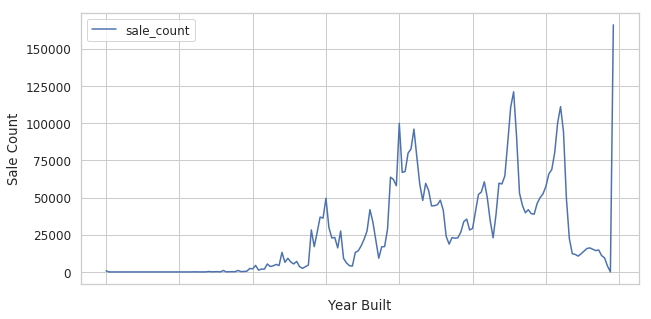

In [127]:
#plot sale count by year built
ax = sales_over_time2.sort_values(by="year_built").plot(kind='line', x='year_built', y='sale_count', figsize=(10,5))
ax.set_xlabel("Year Built")
ax.set_ylabel("Sale Count")


Text(0,0.5,'Average Sale Price')

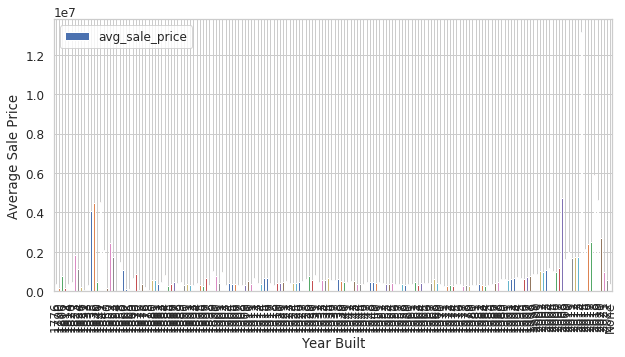

In [128]:
#plot avg sale price by year built
ax = sales_over_time2.sort_values(by="year_built").plot(kind='bar', x='year_built', y='avg_sale_price', figsize=(10,5))
ax.set_xlabel("Year Built")
ax.set_ylabel("Average Sale Price")

### Y variable analysis (classification)

In [130]:
df = df.withColumn(
    'price_flag',
    F.when(F.col("sale_price") > F.col("prev_sale_price"), 1)\
    .otherwise(0)
)

In [131]:
###Aggregate by profit flag: sale count, avg sale price
flag_agg = df.groupBy("price_flag")\
    .agg(F.mean(df.sale_price).alias("avg_sale_price"),
         F.count(df.sale_price).alias("sale_count"),
         F.mean(abs(df.sale_price - df.prev_sale_price)).alias("avg_sale_difference"))\
    .toPandas()
flag_agg['sale_count_perc'] = flag_agg['sale_count']/flag_agg['sale_count'].sum()
flag_agg


,price_flag,avg_sale_price,sale_count,avg_sale_difference,sale_count_perc
0,1,748798.073188,3557881,5.738133e+05,0.791389
1,0,309392.130399,937863,1.079743e+06,0.208611


Text(0,0.5,'Sale Count')

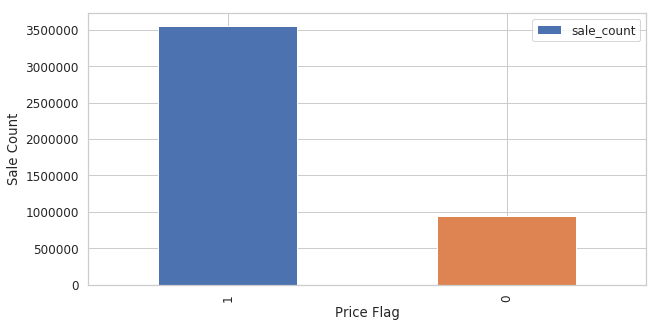

In [132]:
#plot sale count by proft flag
ax = flag_agg.plot(kind='bar', x='price_flag', y='sale_count', figsize=(10,5))
ax.set_xlabel("Price Flag")
ax.set_ylabel("Sale Count")


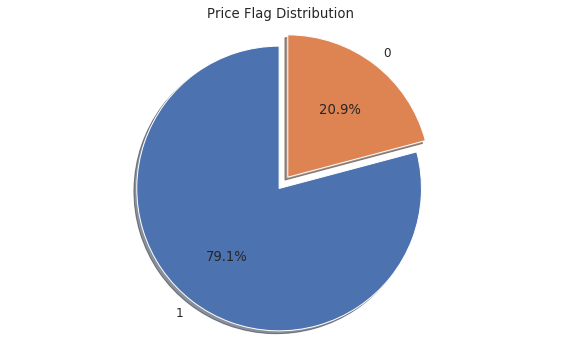

In [133]:
#pie chart for profit flag distribution
import matplotlib.pyplot as plt

# Pie chart
labels = flag_agg['price_flag'].tolist()
sizes = flag_agg['sale_count_perc'].tolist()
# only "explode" the 2nd slice (i.e. 'Hogs')
# explode = (0, 0.1, 0, 0)  
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.title("Price Flag Distribution")

plt.show()


Text(0,0.5,'Price Difference')

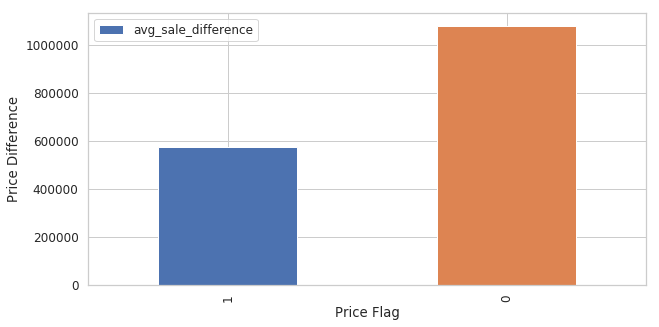

In [134]:
#avg sale difference from previous sale to current sale, by profit flag
ax = flag_agg.plot(kind='bar', x='price_flag', y='avg_sale_difference', figsize=(10,5))
ax.set_xlabel("Price Flag")
ax.set_ylabel("Price Difference")

In [135]:
## zvhi home index

In [136]:
pzvhi = ZVHI.groupBy('StateName').agg(F.avg('ZVHI')).orderBy('avg(ZVHI)',ascending = [0]).toPandas()

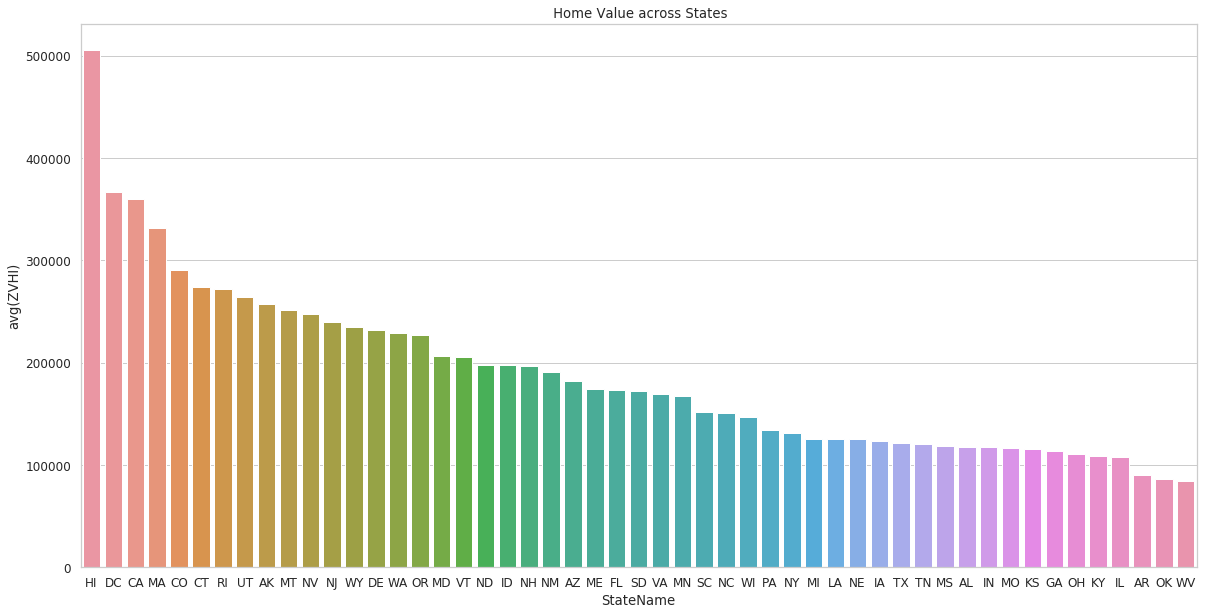

In [137]:
#sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="StateName", y="avg(ZVHI)", data=pzvhi).set(title=' Home Value across States')

In [138]:
pzvhi2 = ZVHI.groupBy('StateName','year').agg(F.avg('ZVHI')).orderBy('avg(ZVHI)',ascending = [0]).toPandas()
top10state=('HI','DC','CA','MA','CO','CT','RI','UT','AK','MT')

[Text(0.5,1,'Home Value Change Overtime for Top Expensive States')]

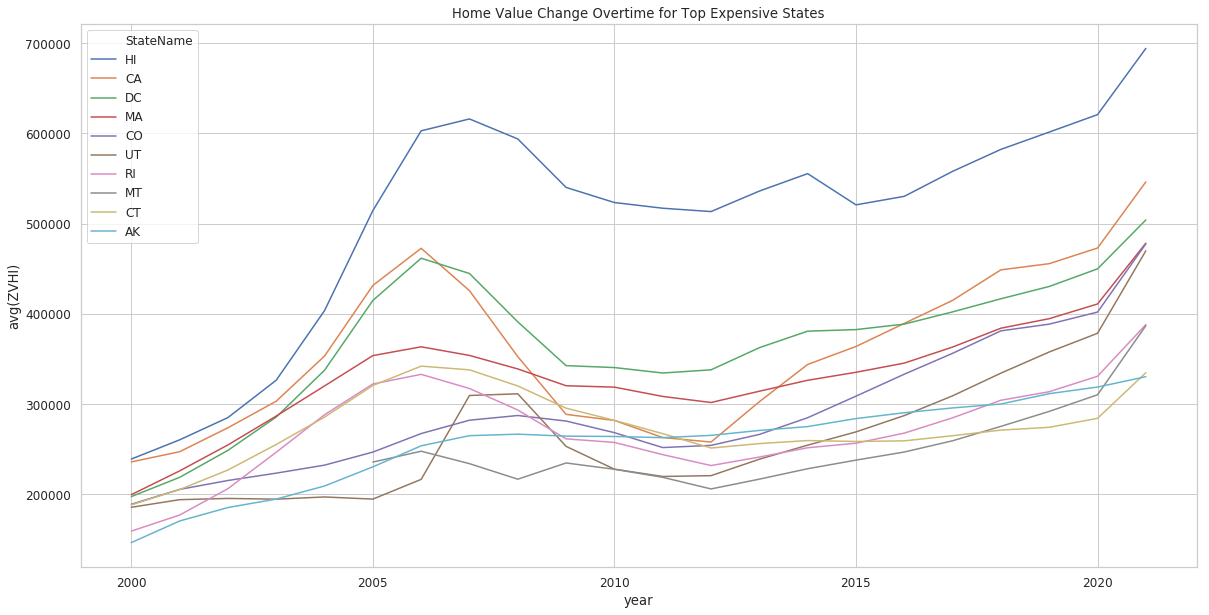

In [139]:
pzvhi2_plot = pzvhi2[(pzvhi2.StateName.isin(top10state))]#.pivot_table('avg(ZVHI)','year','StateName',aggfunc ='mean' )
# sns.set_theme(style="white")
plt.figure(figsize=(20, 10))
sns.lineplot(data=pzvhi2_plot, x="year", y="avg(ZVHI)", hue="StateName").set(title='Home Value Change Overtime for Top Expensive States')


In [140]:
# pzvhi2_plot.sort_values(by="avg(ZVHI)", ascending=False)

In [141]:
# Top 20 cities for home sales
df.select('city','state').groupBy('city', 'state').count().orderBy('count', ascending= False).show(20)

+-------------+-----+------+
|         city|state| count|
+-------------+-----+------+
|  LOS ANGELES|   CA|727220|
|    RIVERSIDE|   CA|234162|
|     LAKELAND|   FL|196748|
|MORENO VALLEY|   CA|131124|
|       CORONA|   CA|119935|
|     PALMDALE|   CA|117179|
|    LANCASTER|   CA|113086|
|   LONG BEACH|   CA| 93372|
| WINTER HAVEN|   FL| 92957|
|         CARY|   NC| 90134|
|NEW YORK CITY|   NY| 90048|
|      RALEIGH|   NC| 89007|
|SANTA CLARITA|   CA| 84789|
|        HEMET|   CA| 79296|
|     TEMECULA|   CA| 77228|
|     MURRIETA|   CA| 76571|
|      MENIFEE|   CA| 63577|
|         APEX|   NC| 53616|
|LAKE ELSINORE|   CA| 49693|
|    LA QUINTA|   CA| 46804|
+-------------+-----+------+
only showing top 20 rows



# FEATURE ENGINEERING

In [144]:
# Convert city, state and zip to numeric categorical
for y in ['city', 'state', 'zip5']:
    print(y)
    indexer = StringIndexer(inputCol=str(y), outputCol=str(y)+"Index")
    ohe = OneHotEncoder(inputCol = str(y)+"Index", outputCol = str(y)+"Vector")
    df = indexer.fit(df).transform(df)
    df = ohe.transform(df)

city
state
zip5


In [ ]:
# # property type clustering
# ## Create pipeline
# # tokenization
# tokenization = Tokenizer(inputCol="property_type", outputCol="p_words")
# # stopwords
# stopwords = StopWordsRemover(inputCol= "p_words", outputCol="p_filtered")
# # some form of dimensionality reduction, word2vec
# word2vec = Word2Vec(vectorSize=5, minCount=0, inputCol="p_filtered", outputCol="propertyVector")

# pipeline = Pipeline().setStages([
#     tokenization,
#     stopwords,
#     word2vec
# ])
# # fit_pipeline = pipeline.fit(df)
# df = pipeline.fit(df).transform(df)
# # df
# # Kmeans
# kmeans = KMeans(featuresCol='propertyVector', predictionCol='propertyClusters', k=10, seed=123, maxIter=5)
# k_mod = kmeans.fit(df)
# df = k_mod.transform(df)

### Feature Reduction

In [145]:
# Remove variables with low stddev
summary = df.describe().toPandas()\
    .set_index("summary").T\
    .sort_values(by="stddev")
summary['stddev'] = pd.to_numeric(summary['stddev'])
summary

summary,count,mean,stddev,min,max
physical_address,4495744,0.0,0.000000e+00,0,YOUNG AVENUE
CRITICAL ACCESS_RATE,4495744,0.0,0.000000e+00,0.0,0.0
CRITICAL ACCESS_CNT,4495744,0.0,0.000000e+00,0,0
CHRONIC DISEASE_RATE,4495744,0.0,0.000000e+00,0.0,0.0
CHRONIC DISEASE_CNT,4495744,0.0,0.000000e+00,0,0
CHILDREN_RATE,4495744,0.0,0.000000e+00,0.0,0.0
REHABILITATION_RATE,4495744,0.0,0.000000e+00,0.0,0.0
WOMEN_CNT,4495744,0.0,0.000000e+00,0,0
WOMEN_RATE,4495744,0.0,0.000000e+00,0.0,0.0
null_CNT,4495744,0.0,0.000000e+00,0,0


In [146]:
drop = summary[summary['stddev'] == 0].index
drop

Index(['physical_address', 'CRITICAL ACCESS_RATE', 'CRITICAL ACCESS_CNT',
       'CHRONIC DISEASE_RATE', 'CHRONIC DISEASE_CNT', 'CHILDREN_RATE',
       'REHABILITATION_RATE', 'WOMEN_CNT', 'WOMEN_RATE', 'null_CNT',
       'MILITARY_RATE', 'null_RATE', 'GOVERNMENT - STATE_RATE',
       'count(MURDER)', 'count(RAPE)', 'count(ROBBERY)', 'count(AGASSLT)',
       'count(BURGLRY)', 'count(MVTHEFT)', 'count(ARSON)', 'sum(population)',
       'avg(crime_rate_per_100000)', 'GOVERNMENT - FEDERAL_RATE',
       'LONG TERM CARE_RATE'],
      dtype='object')

# MODELING (Regression)

### Linear Regression

In [ ]:
#Section 6 - Multiple Linear Regression

In [147]:
from pyspark.ml.feature import VectorAssembler

In [148]:
lin_reg_df = df.filter(df['prev_sale_price'] > 0).na.fill(0)
lin_reg_df = lin_reg_df.withColumn('last_sale_days', datediff('sale_date',col("prev_sale_date")))
lin_reg_df = lin_reg_df.withColumn('last_sale_days', datediff('sale_date',col("prev_sale_date")))
lin_reg_df = lin_reg_df.withColumn('year_built', F.regexp_replace('year_built', ',', '').cast('decimal(12,2)'))
lin_reg_df = lin_reg_df.withColumn('sale_price', F.regexp_replace('sale_price', ',', '').cast('decimal(12,2)')).na.fill(0)
lin_reg_df = lin_reg_df.filter(col('sale_price') <= 1000000).filter(col('sale_price') >= 100000)

In [149]:
#predictors = ['CPIHOSNS', 'city_st_ratio', 'ZVHI','num_sales','zip_num_schools', 'zip_st_ratio', 'Median_Income', 'prev_sale_price']
predictors = ['year_built', 'prev_sale_price', 'last_sale_days', 'CPIHOSNS']

In [150]:
vectorAssembler = VectorAssembler(inputCols = predictors, outputCol = 'features')
vinput_data = vectorAssembler.transform(lin_reg_df)
vinput_data = vinput_data.select(['features', 'sale_price'])
vinput_data.show(1)

+--------------------+----------+
|            features|sale_price|
+--------------------+----------+
|[1974.0,187000.0,...| 267002.00|
+--------------------+----------+
only showing top 1 row



In [151]:
# Train/Test Split
train_df, test_df = vinput_data.randomSplit([.7,.3],seed=1234)

In [152]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='sale_price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-7.424860618247673,0.0010643436945267772,1.6025891524663,1715.846141674514]
Intercept: 12350.48404523792


In [153]:
trainingSummary = lr_model.summary

In [154]:
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 188047.541244
r2: 0.127166


In [155]:
lin_reg_df.select(F.year(col('sale_date'))).distinct().show()

+---------------+
|year(sale_date)|
+---------------+
|           1990|
|           1975|
|           1977|
|           2003|
|           2007|
|           2018|
|           1974|
|           2015|
|           2006|
|           1978|
|           2013|
|           1997|
|           1988|
|           1994|
|           2014|
|           1973|
|           1979|
|           2019|
|           2004|
|           1991|
+---------------+
only showing top 20 rows



In [156]:
lin_reg_df.select(F.year(col('sale_date'))).distinct().orderBy('year(sale_date)', ascending=False)

DataFrame[year(sale_date): int]

### Linear Regression (GLM)

In [160]:
from pyspark.ml.regression import GeneralizedLinearRegression
#ridge
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=5, regParam=0, labelCol='sale_price')
model = glr.fit(train_df)
summary = model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("P Values: " + str(summary.pValues))

Coefficient Standard Errors: [1.4762333601697548, 2.087513612905979e-05, 0.06886344291614542, 4.007572723269698, 3004.5882805649176]
P Values: [4.875561971928732e-07, 0.0, 0.0, 0.0, 3.928637682548697e-05]


In [161]:
linreg_predictions_train = model.transform(train_df)
linreg_predictions_test = model.transform(test_df)

In [163]:
from pyspark.ml.evaluation import RegressionEvaluator

In [164]:
## Train data
lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(linreg_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(linreg_predictions_train)
print("R Squared (R2) on train data = %g" % r2)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(linreg_predictions_train)
print("Mean Absolute Error (MAE) on train data = %g" % mae)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = lr_evaluator.evaluate(linreg_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse)

Root Mean Squared Error (RMSE) on train data = 188048
R Squared (R2) on train data = 0.127166
Mean Absolute Error (MAE) on train data = 146697
Mean Squared Error (MSE) on train data = 3.53619e+10


In [165]:
## Test data
lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(linreg_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(linreg_predictions_test)
print("R Squared (R2) on test data = %g" % r2)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(linreg_predictions_test)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = lr_evaluator.evaluate(linreg_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse)

Root Mean Squared Error (RMSE) on test data = 187987
R Squared (R2) on test data = 0.127782
Mean Absolute Error (MAE) on test data = 146510
Mean Squared Error (MSE) on test data = 3.53391e+10


### Random Forest

In [167]:
from pyspark.ml.regression import RandomForestRegressor

#tf_score_all = [['lable','f1_score','accuracy','ROC']]
rf = RandomForestRegressor(labelCol='sale_price', \
                        featuresCol="features", \
                        numTrees = 2, \
                        maxDepth = 3, \
                        maxBins = 32)
rfm = rf.fit(train_df)

In [168]:
predictions = rfm.transform(test_df)
predictions.select("prediction","sale_price","features").show()

+------------------+----------+--------------------+
|        prediction|sale_price|            features|
+------------------+----------+--------------------+
|247319.88743415585| 400000.00|[0.0,45000.0,90.0...|
|247319.88743415585| 385003.00|[0.0,75000.0,3724...|
| 190941.7473574682| 167500.00|[0.0,85000.0,1088...|
| 287381.4190710476| 175000.00|[0.0,202500.0,348...|
|403820.03609946364| 613525.00|[0.0,370000.0,271...|
|403820.03609946364| 405000.00|[0.0,380000.0,14....|
|426905.54295756074| 365000.00|[1776.0,199090.0,...|
|344085.05225211114| 450000.00|[1890.0,127000.0,...|
| 190941.7473574682| 139500.00|[1894.0,128000.0,...|
|263839.71737938264| 326000.00|[1897.0,189000.0,...|
|451474.64319380315| 606006.00|[1898.0,329003.0,...|
| 605926.8911722586| 721007.00|[1898.0,587505.0,...|
| 515881.4678181364| 641497.00|[1899.0,630000.0,...|
|263839.71737938264| 200000.00|[1900.0,218000.0,...|
|247319.88743415585| 255002.00|[1902.0,95000.0,2...|
|403820.03609946364| 180000.00|[1902.0,330000.

In [169]:
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="sale_price",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.378186


In [170]:
dt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.378186


### Gradient Boosting

In [171]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'sale_price', maxIter=5)
gbt_model = gbt.fit(train_df)

In [172]:
gbt_predictions_train = gbt_model.transform(train_df)
gbt_predictions_test = gbt_model.transform(test_df)

In [173]:
## Train data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions_train)
print("R Squared (R2) on train data = %g" % r2)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator.evaluate(gbt_predictions_train)
print("Mean Absolute Error (MAE) on train data = %g" % mae)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse)

Root Mean Squared Error (RMSE) on train data = 132146
R Squared (R2) on train data = 0.568974
Mean Absolute Error (MAE) on train data = 93911.5
Mean Squared Error (MSE) on train data = 1.74625e+10


In [ ]:
## Test data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions_test)
print("R Squared (R2) on test data = %g" % r2)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse)

Root Mean Squared Error (RMSE) on test data = 132243
R Squared (R2) on test data = 0.56837
Mean Absolute Error (MAE) on test data = 93880.9


In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [ ]:
feature_imp = ExtractFeatureImp(gbt_model.featureImportances, train_df, "features")

In [ ]:
ax = feature_imp.sort_values(by='score', ascending=True).tail(10).plot(kind='barh', x = 'name', y = 'score')\

ax.set_xlabel("Variables")
ax.set_ylabel("Feature Importance")

# MODELING (Classification)

In [ ]:
# ## create flag var
# lin_reg_df = lin_reg_df.withColumn(
#     'price_flag',
#     F.when(F.col("sale_price") > F.col("prev_sale_price"), 1)\
#     .otherwise(0)
# )

In [ ]:
class_df = df.filter(df['prev_sale_price'] > 0).na.fill(0)

In [ ]:
#target variable
class_df = class_df.withColumn('profit_is_pos', (class_df['sale_price'] - class_df['prev_sale_price'] ))
class_df = class_df.withColumn("profit_is_pos", when(F.col('profit_is_pos') >= 0 ,1).otherwise(0))
df_2 = class_df.select('state', 'city', 'zip5', 'year_built', 'CPIHOSNS', 'prev_sale_price',
                       'property_type', 'last_sale_days','profit_is_pos')

In [ ]:
predictors = ['year_built', 'prev_sale_price', 'last_sale_days', 'CPIHOSNS', 'cityVector', 'stateVector', 'zip5Vector']

vectorAssembler = VectorAssembler(inputCols = predictors, outputCol = 'features')
vinput_data = vectorAssembler.transform(df_2)
vinput_data = vinput_data.select(['features', 'profit_is_pos'])
vinput_data.show(1)

### Naive Bayes

In [ ]:
train_df.select('profit_is_pos').groupBy('profit_is_pos').count().show()

In [ ]:
nb = NaiveBayes(modelType='multinomial',labelCol = 'profit_is_pos')
nbmodel = nb.fit(train_df)
predictions_nb = nbmodel.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_nb) 
print("Test accuracy = " + str(nbaccuracy))
Test accuracy = 0.7067928508643422
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="f1") 
nbf1 = evaluator.evaluate(predictions_nb) 
print("Test f1 = " + str(nbf1))
Test f1 = 0.6803030399280371
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedRecall") 
nbcall = evaluator.evaluate(predictions_nb) 
print("Test recall = " + str(nbcall))
Test recall = 0.7067928508643423
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedPrecision") 
nbcall = evaluator.evaluate(predictions_nb) 
print("Precision = " + str(nbcall))
Precision = 0.6787251686730787
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC",labelCol='profit_is_pos')
print("Area under ROC curve:", bcEvaluator.evaluate(predictions_nb))

### Logistic Regression

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,labelCol = 'profit_is_pos')

lrm = lr.fit(train_df)
predictions_lr = lrm.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_lr) 
print("Test accuracy = " + str(nbaccuracy))
Test accuracy = 0.6994104893055962
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="f1") 
nbf1 = evaluator.evaluate(predictions_lr) 
print("Test f1 = " + str(nbf1))
Test f1 = 0.5765969490729765
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedRecall") 
nbcall = evaluator.evaluate(predictions_lr) 
print("Test recall = " + str(nbcall))
Test recall = 0.6994104893055962
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedPrecision") 
nbcall = evaluator.evaluate(predictions_lr) 
print("Precision = " + str(nbcall))
Precision = 0.7082292566625992
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol='profit_is_pos')
print("Area under ROC curve:", bcEvaluator.evaluate(predictions_lr))


### Random Forest

In [ ]:
tf_score_all = [['profit_is_pos','f1_score','accuracy','Recall', 'ROC']]

rf = RandomForestClassifier(labelCol='profit_is_pos', \
                        featuresCol="features", \
                        numTrees = 50, \
                        maxDepth = 3, \
                        maxBins = 32)
rfm = rf.fit(train_df)
predictions = rfm.transform(test_df)
results = predictions.select(['prediction','profit_is_pos'])
predictionAndLabels=results.rdd

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
metrics = MulticlassMetrics(predictionAndLabels)
metrics_binary = BinaryClassificationMetrics(predictionAndLabels)
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions) 
print("Test accuracy = " + str(nbaccuracy))
Test accuracy = 0.69898740111339
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="f1") 
nbf1 = evaluator.evaluate(predictions) 
print("Test f1 = " + str(nbf1))
Test f1 = 0.575146568591468
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedPrecision") 
nbcall = evaluator.evaluate(predictions) 
print("Precision = " + str(nbcall))
Precision = 0.48858338691525116
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedRecall") 
nbcall = evaluator.evaluate(predictions) 
print("Test recall = " + str(nbcall))

In [ ]:
#feature importance
ExtractFeatureImp(mod.stages[-1].featureImportances, df_2, "features_subset") #df2 is the model with highest accuracy

### Gradient Boosting

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol=y_var, featuresCol="features", maxIter=5)
gbt_model = gbt.fit(train_df)

In [ ]:
gbt_predictions_train = gbt_model.transform(train_df)
gbt_predictions_test = gbt_model.transform(test_df)

In [ ]:
gbt_predictions_train.columns

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="price_flag", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="price_flag", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
predictionAndprice_flag = gbt_predictions_train.select("price_flag", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndprice_flag)

In [ ]:
print("Train Data performance")
print(acc)
print(f1)
print(weightedPrecision)
print(weightedRecall)

In [ ]:
## test results

# Make predicitons
predictionAndprice_flag = gbt_predictions_test.select("price_flag", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndprice_flag)

In [ ]:
print("Test Data performance")
print(acc)
print(f1)
print(weightedPrecision)
print(weightedRecall)

In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [ ]:
feature_imp = ExtractFeatureImp(gbt_model.featureImportances, train_df, "features")
feature_imp